# PISA of compensatory MIRT version with a new $\theta$ and Q which evaluated individually

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

In [3]:
raw_df = pd.read_spss("CY07_MSU_STU_COG_testlet.sav")

In [4]:
# All the Process was Carried Out With Pandas

fil1 = raw_df.iloc[:, 13:65]      # Clear All the Information Except Responses

fil2 = fil1.replace(['Full credit', '1 - Full credit', '2 - Full credit', 'No credit', '0 - No credit'], [1, 1, 1, 0, 0])
# Invert All Responses in terms of Binary Codes(1: Correct, 0: Incorrect)

fil3 = fil2.drop('CM955Q03S', axis=1)    # Clear the Item of Multiple Choices
fil4 = fil3.dropna(how='all')            # Clear All Students of No Responses & Clear All Items of No Responses

In [6]:
# DataFrame to Numpy
num_np1 = fil4.to_numpy()

# The Conversion Process to avoid 'divided by zero' error
scarub_np = np.where(num_np1 == 1, 0.99, num_np1)
scourge_np = np.where(scarub_np == 0, 0.01, scarub_np)
num_df = scourge_np                                     # Caution!! num_df is of numpy, not of pandas!!

# print(num_df)

num_dfdf = pd.DataFrame(num_df)                         # num_dfdf is, at last, of pandas!
p_solves = num_dfdf.notnull().sum(1)                    # count the number of responses regardless of NaN

# Data shape
rows, columns = num_df.shape
# print(rows, columns)


### initial variables accomplishment

In [7]:
p_df = num_dfdf.copy()
num_np = num_dfdf.to_numpy()

# theta_1 initialization
row_pre = p_df.mean(axis=1)
row_prob_1 = row_pre.to_numpy()
row_prob = np.reshape(row_prob_1, (rows,1))

theta_1 = np.log(row_prob/(1-row_prob))

# d initialization
col_pre = p_df.mean(axis=0)
col_prob_1 = col_pre.to_numpy()
col_prob = np.array([col_prob_1])
d0 = np.log(col_prob/(1-col_prob))
d = np.mean(d0) - d0

# alpha_1 and alpha_2 initialization
alpha = np.ones((1,columns))

A = 0.005            # learning rate

# transformation of (1,0) binary responses into (1,-1) binary responses
num_exp1 = num_np.copy()
num_exp2 = np.where(num_exp1 == 0.01, -0.99, num_exp1) # transformation

num_exp_df = pd.DataFrame(num_exp2)
num_exp_af = num_exp_df.fillna(0)                 # get rid of NaN
num_exp_np = num_exp_af.to_numpy()

# Q initialization
Q_np_ini = np.ones((columns, columns))
np.fill_diagonal(Q_np_ini, 0)
Q_halves = Q_np_ini / 2

# theta_2 initialization
shell_list = []

for i in range(rows):
    garo_pre = num_exp_np[i, :]
    garo_T = np.reshape(garo_pre, (columns, 1))   # vertial vector form
    sero = garo_T.copy()
    garo = np.transpose(garo_T)
    carrier = sero * garo                   
    np.fill_diagonal(carrier, 0)                 # off-diagonal

    shell_list.append(carrier)

shell_ini = np.array(shell_list)          # initial combination of Y_iY_j

# the reference to indicate the location of solved items
Y_solved0 = num_np.copy()
Y_solved1 = np.where(Y_solved0 == 0.01, 1, Y_solved0)
Y_solved2 = np.where(Y_solved1 == 0.99, 1, Y_solved1)
Y_pd = pd.DataFrame(Y_solved2)
Y_fna = Y_pd.fillna(0)         # set NaN as zero
Y_solved = Y_fna.to_numpy()

Yij_solved = []

for i in range(rows):
    garo_pre = Y_solved[i, :]
    garo_T = np.reshape(garo_pre, (columns, 1))
    sero = garo_T.copy()
    garo = np.transpose(garo_T)
    carrier = sero * garo                   
    np.fill_diagonal(carrier, 0)            

    Yij_solved.append(carrier)

Yij_shell = np.array(Yij_solved)

denominator = []
for i in range(rows):
    bf_Qsum = Yij_shell[i] * Q_halves
    af_Qsum = bf_Qsum.sum()
    denominator.append(af_Qsum)        # generation of the denominator

P_carrier = []     # basket for initial pseudo-probability
for i in range(rows):
    garo_pre = num_exp_np[i, :]
    garo = np.reshape(garo_pre, (1, columns))
    sero_T = np.copy(garo)
    sero = np.transpose(sero_T)

    vectorman1 = sero * garo
    vectorman11 = Q_halves * vectorman1
    vectorman111 = vectorman11.sum(axis=1)
    vectorman2 = vectorman111.sum(axis=0)

    if denominator[i] == 0:
        P_mu = 0
    else:
        P_mu = vectorman2 / denominator[i]

    P_carrier.append(P_mu)

P_norm = np.array(P_carrier)

theta_pre = (49/98.01) * (P_norm) + 0.5    # final form of pseudo-probability initialization

# final initialization of theta_2
theta1_bfT = np.log(theta_pre / (1 - theta_pre))
theta_2 = np.reshape(theta1_bfT, (rows,1))

### 2D covariance를 위한 엄선된 자료

In [7]:
num_exp1 = num_np.copy()
num_exp2 = np.where(num_exp1 == 0.01, -0.99, num_exp1) # transformation

num_exp_df = pd.DataFrame(num_exp2)
num_exp_af = num_exp_df.fillna(0)                 # get rid of NaN
num_exp_np = num_exp_af.to_numpy()                # NaN만 0으로 치환하고, 다시 numpy 형식으로 환원


In [8]:
# 개인 정답률 weight default값 도입 (2D로 시작)
Q_np_ini = np.ones((columns, columns))
np.fill_diagonal(Q_np_ini, 0)
Q_halves = Q_np_ini / 2

# 개인 covariance 도출(3D Tensor 형태)
shell_list = []

for i in range(rows):
    garo_pre = num_exp_np[i, :]
    garo_T = np.reshape(garo_pre, (columns, 1))   # 2D짜리 세로모양 numpy vector로 변환
    sero = garo_T.copy()
    garo = np.transpose(garo_T)
    carrier = sero * garo                    # 2D짜리 column X column Y_i Y_j 조합 생성 (대각선 기준 대칭형태)
    np.fill_diagonal(carrier, 0)                 # 대각선 성분을 모두 0으로 비워버림

    shell_list.append(carrier)

shell_ini = np.array(shell_list)          # 얘가 Initial 값
print(shell_ini.shape)
print(shell_ini)

(2727, 51, 51)
[[[ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  ...
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]]

 [[ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  ...
  [ 0.      0.      0.     ...  0.      0.      0.9801]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.9801  0.      0.    ]]

 [[ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  ...
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.     

## Resume Calculation

### Set Position each Examinee Responded

In [13]:
Y_solved1 = np.where(num_np1 == 0, 1, num_np1)
Y_pd = pd.DataFrame(Y_solved1)
Y_fna = Y_pd.fillna(0)
Y_solved = Y_fna.to_numpy()
print(Y_solved)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [99]:
Y_solved00 = num_np.copy()
Y_solved01 = np.where(Y_solved00 == 0.01, 1, Y_solved00)
print(Y_solved01)
Y_solved02 = np.where(Y_solved01 == 0.99, 1, Y_solved01)
print(Y_solved02)
Y_pd1 = pd.DataFrame(Y_solved02)
Y_fna1 = Y_pd1.fillna(0)
Y_solved1 = Y_fna1.to_numpy()
print(Y_solved1)

[[ nan  nan  nan ...  nan  nan  nan]
 [ nan  nan  nan ... 0.99  nan 0.99]
 [ nan  nan  nan ...  nan  nan  nan]
 ...
 [ nan  nan  nan ... 0.99 1.   0.99]
 [ nan  nan  nan ... 0.99  nan 1.  ]
 [1.   0.99 0.99 ...  nan  nan  nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ...  1. nan  1.]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ...  1.  1.  1.]
 [nan nan nan ...  1. nan  1.]
 [ 1.  1.  1. ... nan nan nan]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [15]:
Yij_solved = []

for i in range(rows):
    garo_pre = Y_solved[i, :]
    garo_T = np.reshape(garo_pre, (columns, 1))   # 2D짜리 세로모양 numpy vector로 변환
    sero = garo_T.copy()
    garo = np.transpose(garo_T)
    carrier = sero * garo                    # 2D짜리 column X column Y_i Y_j 조합 생성 (대각선 기준 대칭형태)
    np.fill_diagonal(carrier, 0)                 # 대각선 성분을 모두 0으로 비워버림

    Yij_solved.append(carrier)

Yij_shell = np.array(Yij_solved)          # 얘가 Initial 값
print(Yij_shell.shape)
print(Yij_shell)

(2727, 51, 51)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 1. 0. 1.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 0. 0.]]

 [[0. 1. 1. ... 0. 0. 0.]
  [1. 0. 1. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0

### Compensatory MIRT model initialization

In [18]:
# 각 성분별 P값 도출 (실험군)
exp1 = alpha * theta
exp2 = alpha * theta1

ex_prob = np.exp(exp1 + exp2 - d)/(1+np.exp(exp1 + exp2 - d))
print(ex_prob)

[[0.9610866  0.95277828 0.95555518 ... 0.90967716 0.60900253 0.90299594]
 [0.88086854 0.85796418 0.86552978 ... 0.75094417 0.31801181 0.73592987]
 [0.84772495 0.81975228 0.82894746 ... 0.69420263 0.25985221 0.6772379 ]
 ...
 [0.96611279 0.95883163 0.96126703 ... 0.92079634 0.64259346 0.91486064]
 [0.58871446 0.53903437 0.55477227 ... 0.36856614 0.08279593 0.35043968]
 [0.69742787 0.65314259 0.6673886  ... 0.48451816 0.12691391 0.46488757]]


In [19]:
# 결측치 반영한 P 행렬 도출 (실험군)
ex_prob_real = ex_prob.copy()

for n in range(ex_prob.shape[0]):
    for m in range(ex_prob.shape[1]):
        if np.isnan(num_df[n][m]):
            ex_prob_real[n][m] = np.nan
            
print(ex_prob_real)


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ... 0.75094417        nan 0.73592987]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ... 0.92079634 0.64259346 0.91486064]
 [       nan        nan        nan ... 0.36856614        nan 0.35043968]
 [0.69742787 0.65314259 0.6673886  ...        nan        nan        nan]]


In [20]:
# Kullbeck Leibler Divergence값 도출

# 각 사람이 각 문제에 대한 KLD 도출
KLD_indiv = num_df * np.log(num_df / ex_prob_real) + (1 - num_df) * np.log((1 - num_df) / (1 - ex_prob_real))
print(KLD_indiv)

# NaN 쌈싸먹기 위한 dataframe 변환 후 제자리
KLD_indiv_df = pd.DataFrame(KLD_indiv)
KLD_NaNga_df = KLD_indiv_df.fillna(0)
KLD_NaNga_np = KLD_NaNga_df.to_numpy()
print(KLD_NaNga_np)

# KLD 최초도출
KLD_RowSum = np.sum(KLD_NaNga_np, axis=1)
KLD_TotalSum_np = np.sum(KLD_RowSum, axis=0)
print(KLD_TotalSum_np)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ... 0.24145898        nan 0.26086812]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ... 0.05104702 0.96701345 0.05672682]
 [       nan        nan        nan ... 0.93674982        nan 0.38162911]
 [1.13108324 0.37628709 0.35534524 ...        nan        nan        nan]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.24145898 0.         0.26086812]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.05104702 0.96701345 0.05672682]
 [0.         0.         0.         ... 0.93674982 0.         0.38162911]
 [1.13108324 0.37628709 0.35534524 ... 0.         0.         0.        ]]
17624.28778851659


## Real NDG Process

In [21]:
def expect_model(alpha_let, alpha2le, d_let, theta_let, theta2le):
#    theta_T = np.transpose(theta_let)              # theta를 세로로 세우기
    
    exponet_1 = alpha_let * theta_let
    exponet_2 = alpha2le * theta2le
    
    before_nan = np.exp(exponet_1 + exponet_2 - d_let)/(1+np.exp(exponet_1 + exponet_2 - d_let))
    after_nan = before_nan.copy()
    
    # 순진한 모델값에 구멍 뚫어버리기
    for n in range(before_nan.shape[0]):
        for m in range(before_nan.shape[1]):
            if np.isnan(num_df[n][m]):
                after_nan[n][m] = np.nan
    
    # 너덜해진 모델값의 모난 부분 절단
    scarub = np.where(after_nan > 0.99, 0.99, after_nan)
    scourge = np.where(scarub < 0.01, 0.01, scarub)
    model_result = scourge
    
    return model_result                              # numpy 형태로 return


In [22]:
# D_KL 미분계수 계산 시 공통부분을 계산하는 함수

def preprocess_diff(alpha_let, alpha2le, d_let, theta_let, theta2le):
    
    p_imu = expect_model(alpha_let, alpha2le, d_let, theta_let, theta2le)    # 그냥 p_imu 일일이 계산하기 귀찮아서... 일단 2D로 추출
    q_imu = num_df.copy()                                                    # 얘는 그냥 대조군

    # 바로 p와 q 조합
    KLD_common = p_imu - q_imu           # 항상 우려먹을 공통부분: '사람 X 문항' 형태
    
    return KLD_common                   # 형태는 numpy array 2D -> num_df와 같은 형태 but 결측치를 제거하지는 않음

In [23]:
# alpha값 갱신하는 함수
# theta_let, beta_let, alpha_let은 np
def set_alpha(alpha_let, alpha2le, d_let, theta_let, theta2le):
    
    # 밑재료 만들기
    common_unit = preprocess_diff(alpha_let, alpha2le, d_let, theta_let, theta2le)       # 결측치 부분이 이미 0으로 처리된 상태로 추출 (numpy 형태)
    
    # 요리 시작
    delta_matrix = theta_let * common_unit                               # 인원 summation 하기 전 (np)
    
    dmatrix_df = pd.DataFrame(delta_matrix)                              # fillna 처리하기 위한 DataFrame 임시도입
    dmatrix_fna = dmatrix_df.fillna(0)                                   # NaN 무시하고 smooth하게 계산하기 위한 기반 다지기
    delta_matrix2 = dmatrix_fna.to_numpy()
    
    delta_alphak = delta_matrix2.sum(axis=0, keepdims = True)            # 인원 summation 직후 (문제당 alpha 맞추기 위한 summation)
    
    alpha_med = alpha_let - A * delta_alphak                             # Gradient Descent 방식으로 D_KL의 alpha 업데이트
    alpha_result = alpha_med
    
    # 결과값은 np 형태로 추출
    return alpha_result

In [24]:
# 의문의 delta값 갱신하는 함수
# theta_let, delta_let, alpha_let은 np
def set_delta(alpha_let, alpha2le, d_let, theta_let, theta2le):
    
    # 밑재료 만들기
    common_unit = preprocess_diff(alpha_let, alpha2le, d_let, theta_let, theta2le)       # 결측치 부분이 이미 0으로 처리된 상태로 추출 (numpy 형태)
    
    # 요리 시작
    delta_matrix = (-1) * common_unit                                                # 인원 summation 하기 전
    
    # 결측치 제거
    dmatrix_df = pd.DataFrame(delta_matrix)                                          # fillna 처리하기 위한 DataFrame 임시도입
    dmatrix_fna = dmatrix_df.fillna(0)                                               # NaN 무시하고 smooth하게 계산하기 위한 기반 다지기
    delta_matrix2 = dmatrix_fna.to_numpy()
    
    delta_dtak = delta_matrix2.sum(axis=0, keepdims = True)                         # 인원 summation 직후 (문제당 alpha 맞추기 위한 summation)
    
    d_med = d_let - A * delta_dtak                                            # Gradient Descent 방식으로 D_KL의 delta 업데이트
    d_result = d_med - np.mean(d_med)
    
    # 결과값은 np 형태로 추출
    return d_result

In [25]:
def update_theta(alpha_let, alpha2le, d_let, theta_let, theta2le):
    
    # 밑재료 만들기
    common_unit = preprocess_diff(alpha_let, alpha2le, d_let, theta_let, theta2le)   # 결측치 부분이 이미 0으로 처리된 상태로 추출 (numpy 형태)
    
    # 요리 시작
    delta_matrix = alpha_let * common_unit                                           # summation 하기 전
    
    # 결측치 제거
    dmatrix_df = pd.DataFrame(delta_matrix)                                          # fillna 처리하기 위한 DataFrame 임시도입
    dmatrix_fna = dmatrix_df.fillna(0)                                               # NaN 무시하고 smooth하게 계산하기 위한 기반 다지기
    delta_matrix2 = dmatrix_fna.to_numpy()
    
    delta_thetak = delta_matrix2.sum(axis=1, keepdims = True)   # summation 직후 (문제당 beta 맞추기 위한 summation)
        
    theta_update = theta_let - A * delta_thetak                 # Gradient Descent 방식으로 D_KL 업데이트
    
    # 결과값은 np 형태로 추출
    return theta_update

### $\theta_{2}$ Update

In [26]:
def Shell_gagong(samjin_data, Q_let):              # gagonged_data는 불변인 DataFrame, Q_let은 계속 변화
    # gagonged_data는 -1, 1 및 결측치 0처리 된 상태로 도입, numpy 형태로 도임
    
    num_gagong = samjin_data.copy()
    rows_let = num_gagong.shape[0]
    columns_let = num_gagong.shape[1]

    # 개인 covariance 도출(3D Tensor 형태)
    shell_list = []

    for i in range(rows_let):
        garo_pre = num_gagong[i, :]                  # 1D짜리 numpy vector가 추출됨
        garo_T = np.reshape(garo_pre, (columns_let, 1))   # 2D짜리 세로모양 numpy vector로 변환
        sero = garo_T.copy()
        garo = np.transpose(garo_T)
        shell_rough = sero * garo                    # 2D짜리 column X column Y_i Y_j 조합 생성 (대각선 기준 대칭형태)

        carrier = Q_let * shell_rough                # 가중치 행렬 Q_ij를 입힌 모습
        np.fill_diagonal(carrier, 0)                 # 대각선 성분을 모두 0으로 비워버림

        shell_list.append(carrier)

    shell_result = np.array(shell_list)          # 결과물 (3D Tensor 형태)
    
    return shell_result

In [27]:
# '필수요소' 점검 탭
# 학생 covariance률 구하는 함수
def answer_covari_bfsum(gagong_data, Q_let):                # gagong_dats는 불변, 최종적으로 P_2 계산 목적

    # 개인 정답률 weight default값 도입 (2D로 시작)
    num_gagong_bf = gagong_data.to_numpy()
    rows_let = num_gagong_bf.shape[0]
    columns_let = num_gagong_bf.shape[1]
    Yij_shell_let = Yij_shell.copy()     # finding items responded by each examinee

    Q_np = Q_let.copy()              # 가공 시작
    
    # 0, 1 데이터를 -1, 1 데이터로 변환 (결측치는 0 처리)
    num_gagonged_bf = np.where(num_gagong_bf == 0.01, -0.99, num_gagong_bf)
    num_gag_pd = pd.DataFrame(num_gagonged_bf)
    num_gag_fna = num_gag_pd.fillna(0)
    num_gagonged_np = num_gag_fna.to_numpy()
    
    p_bfsum = Shell_gagong(num_gagonged_np, Q_np)       # P계산을 위한 밑재료만 제공, 아직 normalization 안 된 상태

#---------------------------------------------------simple sum up ------------- Normalization down ---------------------------------------
    
    #Normalization 재료 만들기
    
    denomin = []
    # denominator 생성
    for i in range(rows):
        bf_Qsam = Yij_shell[i] * Q_let
        af_Qsam = bf_Qsam.sum()
        denomin.append(af_Qsam)

    P2_carrier = p_bfsum.copy()          # 3D Tensor
    
    # P2 뽑아내기 (합계 내기 직전)
    for i in range(rows_let):
        if denomin[i] == 0:
            P2_carrier[i] = 0 * P2_carrier[i]
        else:
            P2_carrier[i] = P2_carrier[i] / denomin[i]
    
    return P2_carrier
        

In [28]:
def answer_covari_afsum(gagong_data, Q_let):
    
    # P2 밑재료 초벌 가공(합)
    p_bfsum = answer_covari_bfsum(gagong_data, Q_let) # normalized by Q_sum
    gagong_np = gagong_data.to_numpy()
    rows_let = gagong_np.shape[0]
    columns_let = gagong_np.shape[1]
    
    covari_ini = p_bfsum.sum(axis=2)
    covari_mid = covari_ini.sum(axis=1)
    covari_carry = np.reshape(covari_mid, (rows_let, 1))      # 세로 모양 벡터 형태 유지

    # theta 만들 수 있도록 normalization (다시 0,1 데이터로 복귀)

    mid_result = (49/98.01) * (covari_carry) + 0.5
    
    # 너덜해진 모델값의 모난 부분 절단
    scarub = np.where(mid_result > 0.99, 0.99, mid_result)
    scourge = np.where(scarub < 0.01, 0.01, scarub)
    P2_result = scourge
        
    return P2_result       # pseudo-probability synthesized

In [29]:
def Q_deriv(alp1, alp2, d_let, tht1, tht2, Q_let, gagong_data):

    # 개인 정답률 weight default값 도입 (2D로 시작)
    num_gagong_bf = gagong_data.to_numpy()
    rows_let = num_gagong_bf.shape[0]
    columns_let = num_gagong_bf.shape[1]
    Yij_shell_let = Yij_shell.copy()

    Q_np = Q_let.copy()              # 가공 시작
    Q_nuul = Q_halves.copy()           # 얘는 from Universal Matrix
    
    # 0, 1 데이터를 -1, 1 데이터로 변환 (결측치는 0 처리)
    num_gagonged_bf = np.where(num_gagong_bf == 0.01, -0.99, num_gagong_bf)
    num_gag_pd = pd.DataFrame(num_gagonged_bf)
    num_gag_fna = num_gag_pd.fillna(0)
    num_gagonged_np = num_gag_fna.to_numpy()
    
    p_bfsum_nossi = Shell_gagong(num_gagonged_np, Q_nuul)
    p_bfsum = Shell_gagong(num_gagonged_np, Q_np)       # P계산을 위한 밑재료만 제공, 아직 normalization 안 된 상태

#---------------------------------------------------simple sum up ------------- Normalization down ---------------------------------------
    
    #Normalization 재료 만들기
    
    denomin = []
    # denominator 생성
    for i in range(rows):
        bf_Qsam = Yij_shell[i] * Q_let
        af_Qsam = bf_Qsam.sum()
        denomin.append(af_Qsam)

    P2_carrier1 = p_bfsum_nossi.copy()
    P2_carrier20 = p_bfsum.copy()          # 3D Tensor

    # P2 1번째 항 뽑아내기 (합계 내기 직전)
    for i in range(rows_let):
        if denomin[i] == 0:
            P2_carrier1[i] = 0 * P2_carrier1[i]
        else:
            P2_carrier1[i] = P2_carrier1[i] / denomin[i]

    # P2 2번째 항 뽑아내기 (합계 내기 직전)
    for i in range(rows_let):
        if denomin[i] == 0:
            P2_carrier20[i] = 0 * P2_carrier20[i]
        else:
            P2_carrier20[i] = P2_carrier20[i] / (denomin[i] * denomin[i])
            
    covari2_ini = P2_carrier20.sum(axis=2)
    covari2_mid = covari2_ini.sum(axis=1)
    P22_part = np.reshape(covari2_mid, (rows_let, 1))      # 세로 모양 벡터 형태 유지
    
    P2_list = []
    for i in range(rows_let):
        carrier = Yij_shell_let[i] * P22_part[i]
        P2_list.append(carrier)
    
    P2_carrier2 = np.array(P2_list)
    
    return P2_carrier1, P2_carrier2
        

In [30]:
def Q_learn(alp1, alp2, d_let, tht1, tht2, Q_let, gagong_data):
    
    Q_np_test = Q_let.copy()           # 얘가 learning 시키는 Matrix
    gagonged_data = gagong_data.to_numpy()
    rows_let = gagonged_data.shape[0]
    columns_let = gagonged_data.shape[1]

    # theta 건들기 전에 할 수 있는 미분 chain
    P2_mu = answer_covari_afsum(gagong_data, Q_np_test)
    Normed_Y = (49/98.01) * (Q_deriv(alp1, alp2, d_let, tht1, tht2, Q_let, gagong_data)[0] - Q_deriv(alp1, alp2, d_let, tht1, tht2, Q_let, gagong_data)[1])

#---------------------------------------------------3D up ------------- 2D down ----------------------------------------------------------
    
    # '공통부분' 끌올 (밑재료 준비)
    com_pt = preprocess_diff(alp1, alp2, d_let, tht1, tht2)   # 결측치 부분이 이미 0으로 처리된 상태로 추출 (numpy 형태)

    # '공통부분' 끌올 (요리 시작)
    common_unit_np = com_pt * alp1                                    # 일단 2D Matrix 형태로 도출 (Q와는 따로 노는 Matrix)
        
    common_unit_T = np.transpose(common_unit_np)                      # '문항 X 사람' 형태로 변환 (mu가 axis=1에 해당; 3D의 mu와 연동 목적)
    decoy_1st = pd.DataFrame(common_unit_T)
    decoy_2nd = decoy_1st.fillna(0)
    common_unit = decoy_2nd.to_numpy()                                 # 4D List로 변환 준비 끝

#-----------------------------------Now, it's time to build a 4D tensor ------------------------------------------------------------------
    
    P_hat_list = []                                                    # 4D Tensor 담을 list 생성 (4D Tensor라니... 미친듯이 무섭군요..!!)
    P_hat_3D = []                                                      # 3D Tensor 일부분을 담을 list 생성
    carrier_2D = []

    for i in range(columns_let):
        for j in range(columns_let):
            for mu in range(rows_let):
                carrier = common_unit[:, mu] * Normed_Y[mu, i, j] / (P2_mu[mu, 0] * (1 - P2_mu[mu, 0]))
                carrier_2D.append(carrier)
            P_hat_3D.append(carrier_2D)          # 4D Tensor로 재조합하기 위해 P_hat_list를 채운 모습 i, jth 성부 채우기
            carrier_2D = []                      # carrier_2D를 재활용 하기 위해 내용물을 비운 모습
        P_hat_list.append(P_hat_3D)              # 드디어 ith 완성
        P_hat_3D = []                            # P_hat_3D를 재활용 하기 위해 내용물을 비운 모습
        
    P_hat_np = np.array(P_hat_list)              # 4D Tensor로 완성된 모습 (여기서 i, j는 냅두고, k와 mu를 모두 더해서 없애야 함) (이때 0은 k, 1은 mu, 2, 3은 각각 i, j)

    # KLD Gradient Discent
    Q_pre = P_hat_np.sum(axis=3)                                 # 4D Tensor는 극혐이므로, 여기선 keepdims를 하지 않는다. (4D -> 3D); 여기는 mu 없애는 부분
    Q_presum = Q_pre.sum(axis=2)                              # 3D Tensor 역시 극혐이므로, keepdims를 하지 않는다. (3D -> 2D); 여기는 k 없애는 부분
    
    # Final Gradient Descendent: update
    Q_med = Q_np_test - A * Q_presum
    np.fill_diagonal(Q_med, 0)
    Q_result = Q_med/(2 * Q_med.mean())                                  # Normalization 대용; 대각선 아닌 모든 성분의 평균이 0.5가 되도록 세팅

    # 결과값은 np 형태로 추출
    return Q_result                                                     # 2D matrix로 return


In [31]:
# theta값 갱신하는 함수
# update된 w 사용해서 직접 theta를 update 시킴. Gradient Discent 사용 안 함
# w_let은 np
def set_theta_Q(gagong_data, Q_let):
    
    rate_result = answer_covari_afsum(gagong_data, Q_let)
    
    theta_result = np.log((rate_result)/(1 - rate_result))
    
    # 결과값은 np 형태로 추출
    return theta_result

In [32]:
# D_KL값 도출하는 함수
# alpha_let, beta_let, theta_let, num_df_let 모두 np
def set_D_KL(alpha_let, alpha2le, d_let, theta_let, theta2le):
    
    P_imu = expect_model(alpha_let, alpha2le, d_let, theta_let, theta2le)
    Q_imu = num_df.copy()
    
    KLD_imu_np = Q_imu * np.log((Q_imu) / (P_imu)) + (1 - Q_imu) * np.log((1 - Q_imu)/(1 - P_imu))
    
    # 잠깐 df로 바꿔치기 (fillna 원툴)
    KLD_imu_df = pd.DataFrame(KLD_imu_np)
    KLD_shuttle = KLD_imu_df.fillna(0)
    KLD_imu = KLD_shuttle.to_numpy()
    
    D_KL_mu = KLD_imu.sum(axis=1)
    D_KL = D_KL_mu.sum(axis=0)
    
    return D_KL

In [36]:
from tqdm import tqdm

In [37]:
alpha1_test = alpha.copy()
alpha2_test = alpha.copy()
d_test = d.copy()
#w_test = w_np.copy()
Q_test = Q_halves.copy()
theta1_test = theta.copy()
theta2_test = theta1.copy()
KLD_test = KLD_TotalSum_np.copy()
KLD_basket = []
KLD_basket.append(KLD_test)

# 본격 Iteration 굴리는 파트
# Learning Rate 설정
A = 0.008
limit = 300
for k in tqdm(range(limit)):
    # alpha1값 갱신
    alpha1_carrier = set_alpha(alpha1_test, alpha2_test, d_test, theta1_test, theta2_test)
    alpha1_test = alpha1_carrier
    #print("%d 번째 Alpha 값 = " % (k+1), alpha_test)

    # alpha2값 갱신
    alpha2_carrier = set_alpha(alpha2_test, alpha1_test, d_test, theta2_test, theta1_test)
    alpha2_test = alpha2_carrier
    #print("%d 번째 Alpha 값 = " % (k+1), alpha_test)

    # d값 갱신
    delta_carrier = set_delta(alpha1_test, alpha2_test, d_test, theta1_test, theta2_test)
    d_test = delta_carrier
    #print("%d 번째 Beta 값 = " % (k+1), beta_test)
    
    # Q값 갱신
    Q_carrier = Q_learn(alpha2_test, alpha1_test, d_test, theta2_test, theta1_test, Q_test, num_dfdf)
    Q_test = Q_carrier
    #print("%d 번째 w 벡터 값 = " % (k+1), w_test)
    
    # 노멀 theta값 갱신
    theta1_carrier = update_theta(alpha1_test, alpha2_test, d_test, theta1_test, theta2_test)
    theta1_test = theta1_carrier
    #print("%d 번째 Theta 값 = " % (k+1), theta_test)
    
    # 복잡한 theta2값 갱신
    theta2_carrier = set_theta_Q(num_dfdf, Q_test)
    theta2_test = theta2_carrier
    #print("%d 번째 Theta 값 = " % (k+1), theta_test)

    # Kullback-Leibler Divergence값 도출
    KLD_carrier = set_D_KL(alpha1_test, alpha2_test, d_test, theta1_test, theta2_test)
    print("%d 번째 Kullback-Leibler Divergence 값 = " % (k+1), KLD_carrier)
    
    # 작업을 멈출지 말지 결정
    if (k < limit - 1) and (KLD_carrier < KLD_test):
        KLD_test = KLD_carrier
        KLD_basket.append(KLD_test)
    elif k == limit - 1:
        KLD_test = KLD_carrier
        KLD_basket.append(KLD_test)
        print("최종 ICC 변수 일람")
        print("최종 Kullback-Leibler Divergence 값 = ", KLD_test)
        print("최종 Alpha1 값 = ", alpha1_test)
        print("최종 d 값 = ", d_test)
        #print("최종 w 벡터 값 = ", w_test)
        print("최종 Theta1 값 = ", theta1_test)
        print("최종 Alpha2 값 = ", alpha2_test)
        print("최종 Q 행렬 값 = ", Q_test)
        print("최종 Theta2 값 = ", theta2_test)
    else:
        print("최종 ICC 변수 일람")
        print("최종 Kullback-Leibler Divergence 값 = ", KLD_test)
        print("최종 Alpha1 값 = ", alpha1_test)
        print("최종 d 값 = ", d_test)
        #print("최종 w 벡터 값 = ", w_test)
        print("최종 Theta1 값 = ", theta1_test)
        print("최종 Alpha2 값 = ", alpha2_test)
        print("최종 Q 행렬 값 = ", Q_test)
        print("최종 Theta2 값 = ", theta2_test)
        break

  0%|▎                                                                               | 1/300 [00:25<2:06:44, 25.43s/it]

1 번째 Kullback-Leibler Divergence 값 =  16810.563636913736


  1%|▌                                                                               | 2/300 [00:50<2:04:14, 25.02s/it]

2 번째 Kullback-Leibler Divergence 값 =  16605.18666052237


  1%|▊                                                                               | 3/300 [01:14<2:01:43, 24.59s/it]

3 번째 Kullback-Leibler Divergence 값 =  16517.406226309533


  1%|█                                                                               | 4/300 [01:38<2:00:38, 24.46s/it]

4 번째 Kullback-Leibler Divergence 값 =  16459.48174469282


  2%|█▎                                                                              | 5/300 [02:05<2:05:07, 25.45s/it]

5 번째 Kullback-Leibler Divergence 값 =  16416.490387572085


  2%|█▌                                                                              | 6/300 [02:30<2:03:02, 25.11s/it]

6 번째 Kullback-Leibler Divergence 값 =  16382.307219283235


  2%|█▊                                                                              | 7/300 [02:54<2:01:08, 24.81s/it]

7 번째 Kullback-Leibler Divergence 값 =  16353.667699220938


  3%|██▏                                                                             | 8/300 [03:18<1:59:56, 24.65s/it]

8 번째 Kullback-Leibler Divergence 값 =  16328.733975064892


  3%|██▍                                                                             | 9/300 [03:43<1:59:16, 24.59s/it]

9 번째 Kullback-Leibler Divergence 값 =  16306.23780752613


  3%|██▋                                                                            | 10/300 [04:08<1:59:23, 24.70s/it]

10 번째 Kullback-Leibler Divergence 값 =  16285.55774320543


  4%|██▉                                                                            | 11/300 [04:32<1:58:55, 24.69s/it]

11 번째 Kullback-Leibler Divergence 값 =  16266.368618640696


  4%|███▏                                                                           | 12/300 [04:57<1:59:11, 24.83s/it]

12 번째 Kullback-Leibler Divergence 값 =  16248.296410230321


  4%|███▍                                                                           | 13/300 [05:22<1:58:32, 24.78s/it]

13 번째 Kullback-Leibler Divergence 값 =  16231.104884769382


  5%|███▋                                                                           | 14/300 [05:47<1:57:51, 24.72s/it]

14 번째 Kullback-Leibler Divergence 값 =  16214.585446937479


  5%|███▉                                                                           | 15/300 [06:11<1:57:05, 24.65s/it]

15 번째 Kullback-Leibler Divergence 값 =  16198.577691662033


  5%|████▏                                                                          | 16/300 [06:36<1:56:52, 24.69s/it]

16 번째 Kullback-Leibler Divergence 값 =  16182.85689865226


  6%|████▍                                                                          | 17/300 [07:01<1:56:33, 24.71s/it]

17 번째 Kullback-Leibler Divergence 값 =  16167.43627196865


  6%|████▋                                                                          | 18/300 [07:25<1:56:04, 24.70s/it]

18 번째 Kullback-Leibler Divergence 값 =  16152.094370181152


  6%|█████                                                                          | 19/300 [07:50<1:55:49, 24.73s/it]

19 번째 Kullback-Leibler Divergence 값 =  16136.891308013142


  7%|█████▎                                                                         | 20/300 [08:15<1:55:13, 24.69s/it]

20 번째 Kullback-Leibler Divergence 값 =  16121.7860502289


  7%|█████▌                                                                         | 21/300 [08:40<1:55:17, 24.79s/it]

21 번째 Kullback-Leibler Divergence 값 =  16106.77717166537


  7%|█████▊                                                                         | 22/300 [09:05<1:55:02, 24.83s/it]

22 번째 Kullback-Leibler Divergence 값 =  16091.842062231242


  8%|██████                                                                         | 23/300 [09:29<1:54:31, 24.81s/it]

23 번째 Kullback-Leibler Divergence 값 =  16076.963596967791


  8%|██████▎                                                                        | 24/300 [09:54<1:54:07, 24.81s/it]

24 번째 Kullback-Leibler Divergence 값 =  16062.127133009877


  8%|██████▌                                                                        | 25/300 [10:19<1:54:00, 24.87s/it]

25 번째 Kullback-Leibler Divergence 값 =  16047.324006813005


  9%|██████▊                                                                        | 26/300 [10:44<1:53:53, 24.94s/it]

26 번째 Kullback-Leibler Divergence 값 =  16032.55369059632


  9%|███████                                                                        | 27/300 [11:10<1:54:08, 25.09s/it]

27 번째 Kullback-Leibler Divergence 값 =  16017.845503469314


  9%|███████▎                                                                       | 28/300 [11:35<1:53:29, 25.04s/it]

28 번째 Kullback-Leibler Divergence 값 =  16002.99880579282


 10%|███████▋                                                                       | 29/300 [12:00<1:53:16, 25.08s/it]

29 번째 Kullback-Leibler Divergence 값 =  15988.190002085543


 10%|███████▉                                                                       | 30/300 [12:25<1:53:01, 25.12s/it]

30 번째 Kullback-Leibler Divergence 값 =  15973.409254007383


 10%|████████▏                                                                      | 31/300 [12:50<1:52:28, 25.09s/it]

31 번째 Kullback-Leibler Divergence 값 =  15960.196459288158


 11%|████████▍                                                                      | 32/300 [13:15<1:51:55, 25.06s/it]

32 번째 Kullback-Leibler Divergence 값 =  15945.345707958424


 11%|████████▋                                                                      | 33/300 [13:40<1:51:49, 25.13s/it]

33 번째 Kullback-Leibler Divergence 값 =  15930.598892764941


 11%|████████▉                                                                      | 34/300 [14:05<1:51:21, 25.12s/it]

34 번째 Kullback-Leibler Divergence 값 =  15915.981932133796


 12%|█████████▏                                                                     | 35/300 [14:30<1:50:44, 25.07s/it]

35 번째 Kullback-Leibler Divergence 값 =  15901.45914377082


 12%|█████████▍                                                                     | 36/300 [14:56<1:50:36, 25.14s/it]

36 번째 Kullback-Leibler Divergence 값 =  15887.0817782069


 12%|█████████▋                                                                     | 37/300 [15:21<1:50:30, 25.21s/it]

37 번째 Kullback-Leibler Divergence 값 =  15872.862341190084


 13%|██████████                                                                     | 38/300 [15:46<1:50:06, 25.22s/it]

38 번째 Kullback-Leibler Divergence 값 =  15858.793814948101


 13%|██████████▎                                                                    | 39/300 [16:11<1:49:22, 25.14s/it]

39 번째 Kullback-Leibler Divergence 값 =  15844.92857886478


 13%|██████████▌                                                                    | 40/300 [16:37<1:49:12, 25.20s/it]

40 번째 Kullback-Leibler Divergence 값 =  15831.287607007775


 14%|██████████▊                                                                    | 41/300 [17:02<1:49:17, 25.32s/it]

41 번째 Kullback-Leibler Divergence 값 =  15817.88777625461


 14%|███████████                                                                    | 42/300 [17:28<1:48:59, 25.35s/it]

42 번째 Kullback-Leibler Divergence 값 =  15804.762938791424


 14%|███████████▎                                                                   | 43/300 [17:53<1:48:40, 25.37s/it]

43 번째 Kullback-Leibler Divergence 값 =  15792.09295171592


 15%|███████████▌                                                                   | 44/300 [18:19<1:48:23, 25.40s/it]

44 번째 Kullback-Leibler Divergence 값 =  15780.311640361117


 15%|███████████▊                                                                   | 45/300 [18:44<1:48:08, 25.45s/it]

45 번째 Kullback-Leibler Divergence 값 =  15767.818948417897


 15%|████████████                                                                   | 46/300 [19:10<1:47:41, 25.44s/it]

46 번째 Kullback-Leibler Divergence 값 =  15755.855008683458


 16%|████████████▍                                                                  | 47/300 [19:35<1:47:17, 25.45s/it]

47 번째 Kullback-Leibler Divergence 값 =  15744.491475609128


 16%|████████████▋                                                                  | 48/300 [20:01<1:47:18, 25.55s/it]

48 번째 Kullback-Leibler Divergence 값 =  15732.775319987246


 16%|████████████▉                                                                  | 49/300 [20:26<1:46:59, 25.58s/it]

49 번째 Kullback-Leibler Divergence 값 =  15721.558344242347


 17%|█████████████▏                                                                 | 50/300 [20:52<1:46:47, 25.63s/it]

50 번째 Kullback-Leibler Divergence 값 =  15710.391636913906


 17%|█████████████▍                                                                 | 51/300 [21:18<1:46:08, 25.58s/it]

51 번째 Kullback-Leibler Divergence 값 =  15699.62648028322


 17%|█████████████▋                                                                 | 52/300 [21:44<1:46:34, 25.79s/it]

52 번째 Kullback-Leibler Divergence 값 =  15688.826659840544


 18%|█████████████▉                                                                 | 53/300 [22:09<1:45:49, 25.71s/it]

53 번째 Kullback-Leibler Divergence 값 =  15678.463129334385


 18%|██████████████▏                                                                | 54/300 [22:35<1:44:54, 25.59s/it]

54 번째 Kullback-Leibler Divergence 값 =  15668.027205213199


 18%|██████████████▍                                                                | 55/300 [23:00<1:44:18, 25.55s/it]

55 번째 Kullback-Leibler Divergence 값 =  15657.975430744107


 19%|██████████████▋                                                                | 56/300 [23:26<1:44:10, 25.62s/it]

56 번째 Kullback-Leibler Divergence 값 =  15647.966627143393


 19%|███████████████                                                                | 57/300 [23:52<1:43:52, 25.65s/it]

57 번째 Kullback-Leibler Divergence 값 =  15638.276916547635


 19%|███████████████▎                                                               | 58/300 [24:17<1:43:12, 25.59s/it]

58 번째 Kullback-Leibler Divergence 값 =  15628.68339343993


 20%|███████████████▌                                                               | 59/300 [24:43<1:43:13, 25.70s/it]

59 번째 Kullback-Leibler Divergence 값 =  15619.348084986084


 20%|███████████████▊                                                               | 60/300 [25:09<1:42:48, 25.70s/it]

60 번째 Kullback-Leibler Divergence 값 =  15610.134821388318


 20%|████████████████                                                               | 61/300 [25:35<1:42:25, 25.72s/it]

61 번째 Kullback-Leibler Divergence 값 =  15601.128678825218


 21%|████████████████▎                                                              | 62/300 [26:00<1:42:02, 25.72s/it]

62 번째 Kullback-Leibler Divergence 값 =  15592.277062869834


 21%|████████████████▌                                                              | 63/300 [26:26<1:42:03, 25.84s/it]

63 번째 Kullback-Leibler Divergence 값 =  15583.606431020136


 21%|████████████████▊                                                              | 64/300 [26:52<1:41:35, 25.83s/it]

64 번째 Kullback-Leibler Divergence 값 =  15575.095458170474


 22%|█████████████████                                                              | 65/300 [27:18<1:41:08, 25.82s/it]

65 번째 Kullback-Leibler Divergence 값 =  15566.748472731973


 22%|█████████████████▍                                                             | 66/300 [27:44<1:40:43, 25.83s/it]

66 번째 Kullback-Leibler Divergence 값 =  15558.556727132363


 22%|█████████████████▋                                                             | 67/300 [28:10<1:40:30, 25.88s/it]

67 번째 Kullback-Leibler Divergence 값 =  15550.517182645643


 23%|█████████████████▉                                                             | 68/300 [28:36<1:40:02, 25.87s/it]

68 번째 Kullback-Leibler Divergence 값 =  15542.624334786356


 23%|██████████████████▏                                                            | 69/300 [29:01<1:39:09, 25.75s/it]

69 번째 Kullback-Leibler Divergence 값 =  15534.873430855037


 23%|██████████████████▍                                                            | 70/300 [29:27<1:38:52, 25.79s/it]

70 번째 Kullback-Leibler Divergence 값 =  15527.259019804176


 24%|██████████████████▋                                                            | 71/300 [29:53<1:38:26, 25.79s/it]

71 번째 Kullback-Leibler Divergence 값 =  15519.776190162376


 24%|██████████████████▉                                                            | 72/300 [30:19<1:37:54, 25.76s/it]

72 번째 Kullback-Leibler Divergence 값 =  15512.420228852585


 24%|███████████████████▏                                                           | 73/300 [30:44<1:37:25, 25.75s/it]

73 번째 Kullback-Leibler Divergence 값 =  15505.186222409884


 25%|███████████████████▍                                                           | 74/300 [31:11<1:37:40, 25.93s/it]

74 번째 Kullback-Leibler Divergence 값 =  15498.069339320711


 25%|███████████████████▊                                                           | 75/300 [31:36<1:37:03, 25.88s/it]

75 번째 Kullback-Leibler Divergence 값 =  15491.064782858462


 25%|████████████████████                                                           | 76/300 [32:02<1:36:01, 25.72s/it]

76 번째 Kullback-Leibler Divergence 값 =  15484.167928748935


 26%|████████████████████▎                                                          | 77/300 [32:27<1:35:32, 25.71s/it]

77 번째 Kullback-Leibler Divergence 값 =  15477.374337202913


 26%|████████████████████▌                                                          | 78/300 [32:54<1:35:43, 25.87s/it]

78 번째 Kullback-Leibler Divergence 값 =  15470.67957813976


 26%|████████████████████▊                                                          | 79/300 [33:20<1:35:16, 25.87s/it]

79 번째 Kullback-Leibler Divergence 값 =  15464.079345855085


 27%|█████████████████████                                                          | 80/300 [33:45<1:34:25, 25.75s/it]

80 번째 Kullback-Leibler Divergence 값 =  15457.569655481617


 27%|█████████████████████▎                                                         | 81/300 [34:11<1:34:10, 25.80s/it]

81 번째 Kullback-Leibler Divergence 값 =  15451.146603813362


 27%|█████████████████████▌                                                         | 82/300 [34:37<1:33:48, 25.82s/it]

82 번째 Kullback-Leibler Divergence 값 =  15444.80654239425


 28%|█████████████████████▊                                                         | 83/300 [35:03<1:33:38, 25.89s/it]

83 번째 Kullback-Leibler Divergence 값 =  15438.546338051608


 28%|██████████████████████                                                         | 84/300 [35:28<1:32:51, 25.79s/it]

84 번째 Kullback-Leibler Divergence 값 =  15432.363203823239


 28%|██████████████████████▍                                                        | 85/300 [35:55<1:32:43, 25.88s/it]

85 번째 Kullback-Leibler Divergence 값 =  15426.254391119133


 29%|██████████████████████▋                                                        | 86/300 [36:20<1:32:10, 25.84s/it]

86 번째 Kullback-Leibler Divergence 값 =  15420.217467633163


 29%|██████████████████████▉                                                        | 87/300 [36:46<1:31:48, 25.86s/it]

87 번째 Kullback-Leibler Divergence 값 =  15414.249975935698


 29%|███████████████████████▏                                                       | 88/300 [37:12<1:31:34, 25.92s/it]

88 번째 Kullback-Leibler Divergence 값 =  15408.350412907988


 30%|███████████████████████▍                                                       | 89/300 [37:38<1:31:00, 25.88s/it]

89 번째 Kullback-Leibler Divergence 값 =  15402.517479053284


 30%|███████████████████████▋                                                       | 90/300 [38:04<1:30:22, 25.82s/it]

90 번째 Kullback-Leibler Divergence 값 =  15396.750389161858


 30%|███████████████████████▉                                                       | 91/300 [38:29<1:29:38, 25.74s/it]

91 번째 Kullback-Leibler Divergence 값 =  15391.04904227037


 31%|████████████████████████▏                                                      | 92/300 [38:56<1:29:48, 25.90s/it]

92 번째 Kullback-Leibler Divergence 값 =  15385.413296982122


 31%|████████████████████████▍                                                      | 93/300 [39:21<1:29:23, 25.91s/it]

93 번째 Kullback-Leibler Divergence 값 =  15379.844257996214


 31%|████████████████████████▊                                                      | 94/300 [39:47<1:28:42, 25.83s/it]

94 번째 Kullback-Leibler Divergence 값 =  15374.343789912817


 32%|█████████████████████████                                                      | 95/300 [40:13<1:28:30, 25.90s/it]

95 번째 Kullback-Leibler Divergence 값 =  15368.914416214146


 32%|█████████████████████████▎                                                     | 96/300 [40:39<1:28:09, 25.93s/it]

96 번째 Kullback-Leibler Divergence 값 =  15363.558880494447


 32%|█████████████████████████▌                                                     | 97/300 [41:05<1:27:45, 25.94s/it]

97 번째 Kullback-Leibler Divergence 값 =  15358.280457836026


 33%|█████████████████████████▊                                                     | 98/300 [41:31<1:27:10, 25.89s/it]

98 번째 Kullback-Leibler Divergence 값 =  15353.081880010988


 33%|██████████████████████████                                                     | 99/300 [41:57<1:26:56, 25.95s/it]

99 번째 Kullback-Leibler Divergence 값 =  15347.965465255766


 33%|██████████████████████████                                                    | 100/300 [42:23<1:26:31, 25.96s/it]

100 번째 Kullback-Leibler Divergence 값 =  15342.93228247854


 34%|██████████████████████████▎                                                   | 101/300 [42:49<1:26:34, 26.10s/it]

101 번째 Kullback-Leibler Divergence 값 =  15337.981534300729


 34%|██████████████████████████▌                                                   | 102/300 [43:15<1:25:36, 25.94s/it]

102 번째 Kullback-Leibler Divergence 값 =  15333.110374612901


 34%|██████████████████████████▊                                                   | 103/300 [43:41<1:25:17, 25.98s/it]

103 번째 Kullback-Leibler Divergence 값 =  15328.316333875095


 35%|███████████████████████████                                                   | 104/300 [44:07<1:24:44, 25.94s/it]

104 번째 Kullback-Leibler Divergence 값 =  15323.660239107809


 35%|███████████████████████████▎                                                  | 105/300 [44:33<1:23:59, 25.84s/it]

105 번째 Kullback-Leibler Divergence 값 =  15319.012021012586


 35%|███████████████████████████▌                                                  | 106/300 [44:59<1:24:06, 26.01s/it]

106 번째 Kullback-Leibler Divergence 값 =  15314.407553481828


 36%|███████████████████████████▊                                                  | 107/300 [45:25<1:23:41, 26.02s/it]

107 번째 Kullback-Leibler Divergence 값 =  15309.857815483381


 36%|████████████████████████████                                                  | 108/300 [45:51<1:23:13, 26.01s/it]

108 번째 Kullback-Leibler Divergence 값 =  15305.35612220686


 36%|████████████████████████████▎                                                 | 109/300 [46:17<1:22:35, 25.94s/it]

109 번째 Kullback-Leibler Divergence 값 =  15300.85343876749


 37%|████████████████████████████▌                                                 | 110/300 [46:43<1:22:49, 26.16s/it]

110 번째 Kullback-Leibler Divergence 값 =  15296.377761234686


 37%|████████████████████████████▊                                                 | 111/300 [47:09<1:22:15, 26.11s/it]

111 번째 Kullback-Leibler Divergence 값 =  15291.996271316297


 37%|█████████████████████████████                                                 | 112/300 [47:35<1:21:21, 25.96s/it]

112 번째 Kullback-Leibler Divergence 값 =  15287.57136158337


 38%|█████████████████████████████▍                                                | 113/300 [48:01<1:21:12, 26.06s/it]

113 번째 Kullback-Leibler Divergence 값 =  15283.222346562374


 38%|█████████████████████████████▋                                                | 114/300 [48:27<1:20:41, 26.03s/it]

114 번째 Kullback-Leibler Divergence 값 =  15278.923805533777


 38%|█████████████████████████████▉                                                | 115/300 [48:53<1:20:11, 26.01s/it]

115 번째 Kullback-Leibler Divergence 값 =  15274.671829498568


 39%|██████████████████████████████▏                                               | 116/300 [49:19<1:19:29, 25.92s/it]

116 번째 Kullback-Leibler Divergence 값 =  15270.467115357253


 39%|██████████████████████████████▍                                               | 117/300 [49:45<1:19:17, 25.99s/it]

117 번째 Kullback-Leibler Divergence 값 =  15266.334887669691


 39%|██████████████████████████████▋                                               | 118/300 [50:12<1:19:21, 26.16s/it]

118 번째 Kullback-Leibler Divergence 값 =  15262.192888044101


 40%|██████████████████████████████▉                                               | 119/300 [50:38<1:18:41, 26.09s/it]

119 번째 Kullback-Leibler Divergence 값 =  15258.207753553805


 40%|███████████████████████████████▏                                              | 120/300 [51:04<1:18:37, 26.21s/it]

120 번째 Kullback-Leibler Divergence 값 =  15254.074424890401


 40%|███████████████████████████████▍                                              | 121/300 [51:30<1:18:08, 26.19s/it]

121 번째 Kullback-Leibler Divergence 값 =  15250.034617739291


 41%|███████████████████████████████▋                                              | 122/300 [51:56<1:17:32, 26.14s/it]

122 번째 Kullback-Leibler Divergence 값 =  15246.043322392463


 41%|███████████████████████████████▉                                              | 123/300 [52:22<1:16:47, 26.03s/it]

123 번째 Kullback-Leibler Divergence 값 =  15242.09322886234


 41%|████████████████████████████████▏                                             | 124/300 [52:48<1:16:42, 26.15s/it]

124 번째 Kullback-Leibler Divergence 값 =  15238.182293302416


 42%|████████████████████████████████▌                                             | 125/300 [53:14<1:15:56, 26.04s/it]

125 번째 Kullback-Leibler Divergence 값 =  15234.309150575164


 42%|████████████████████████████████▊                                             | 126/300 [53:40<1:15:00, 25.86s/it]

126 번째 Kullback-Leibler Divergence 값 =  15230.47331618212


 42%|█████████████████████████████████                                             | 127/300 [54:05<1:14:28, 25.83s/it]

127 번째 Kullback-Leibler Divergence 값 =  15226.674120860274


 43%|█████████████████████████████████▎                                            | 128/300 [54:31<1:14:14, 25.90s/it]

128 번째 Kullback-Leibler Divergence 값 =  15222.911360026103


 43%|█████████████████████████████████▌                                            | 129/300 [54:58<1:14:01, 25.98s/it]

129 번째 Kullback-Leibler Divergence 값 =  15219.184836637196


 43%|█████████████████████████████████▊                                            | 130/300 [55:23<1:13:26, 25.92s/it]

130 번째 Kullback-Leibler Divergence 값 =  15215.494607908082


 44%|██████████████████████████████████                                            | 131/300 [55:50<1:13:21, 26.04s/it]

131 번째 Kullback-Leibler Divergence 값 =  15211.840968682773


 44%|██████████████████████████████████▎                                           | 132/300 [56:16<1:12:42, 25.97s/it]

132 번째 Kullback-Leibler Divergence 값 =  15208.2248654942


 44%|██████████████████████████████████▌                                           | 133/300 [56:41<1:11:57, 25.85s/it]

133 번째 Kullback-Leibler Divergence 값 =  15204.649710850264


 45%|██████████████████████████████████▊                                           | 134/300 [57:07<1:11:26, 25.82s/it]

134 번째 Kullback-Leibler Divergence 값 =  15201.13944717102


 45%|███████████████████████████████████                                           | 135/300 [57:33<1:11:20, 25.94s/it]

135 번째 Kullback-Leibler Divergence 값 =  15197.581119249393


 45%|███████████████████████████████████▎                                          | 136/300 [57:59<1:10:58, 25.96s/it]

136 번째 Kullback-Leibler Divergence 값 =  15194.096765327387


 46%|███████████████████████████████████▌                                          | 137/300 [58:25<1:10:31, 25.96s/it]

137 번째 Kullback-Leibler Divergence 값 =  15190.999561621502


 46%|███████████████████████████████████▉                                          | 138/300 [58:51<1:10:27, 26.09s/it]

138 번째 Kullback-Leibler Divergence 값 =  15187.509601036749


 46%|████████████████████████████████████▏                                         | 139/300 [59:17<1:09:54, 26.05s/it]

139 번째 Kullback-Leibler Divergence 값 =  15184.067707728316


 47%|████████████████████████████████████▍                                         | 140/300 [59:43<1:09:21, 26.01s/it]

140 번째 Kullback-Leibler Divergence 값 =  15180.671965025309


 47%|███████████████████████████████████▋                                        | 141/300 [1:00:09<1:08:46, 25.95s/it]

141 번째 Kullback-Leibler Divergence 값 =  15177.319606539144


 47%|███████████████████████████████████▉                                        | 142/300 [1:00:36<1:08:42, 26.09s/it]

142 번째 Kullback-Leibler Divergence 값 =  15174.006644091538


 48%|████████████████████████████████████▏                                       | 143/300 [1:01:02<1:08:13, 26.08s/it]

143 번째 Kullback-Leibler Divergence 값 =  15170.723579974943


 48%|████████████████████████████████████▍                                       | 144/300 [1:01:28<1:07:43, 26.04s/it]

144 번째 Kullback-Leibler Divergence 값 =  15167.462274455338


 48%|████████████████████████████████████▋                                       | 145/300 [1:01:54<1:07:33, 26.15s/it]

145 번째 Kullback-Leibler Divergence 값 =  15164.223291910035


 49%|████████████████████████████████████▉                                       | 146/300 [1:02:20<1:06:56, 26.08s/it]

146 번째 Kullback-Leibler Divergence 값 =  15161.006925710697


 49%|█████████████████████████████████████▏                                      | 147/300 [1:02:46<1:06:34, 26.11s/it]

147 번째 Kullback-Leibler Divergence 값 =  15157.813823118639


 49%|█████████████████████████████████████▍                                      | 148/300 [1:03:12<1:05:58, 26.04s/it]

148 번째 Kullback-Leibler Divergence 값 =  15154.645547338192


 50%|█████████████████████████████████████▋                                      | 149/300 [1:03:38<1:05:46, 26.13s/it]

149 번째 Kullback-Leibler Divergence 값 =  15151.51751574134


 50%|██████████████████████████████████████                                      | 150/300 [1:04:04<1:05:16, 26.11s/it]

150 번째 Kullback-Leibler Divergence 값 =  15148.372701873916


 50%|██████████████████████████████████████▎                                     | 151/300 [1:04:30<1:04:33, 26.00s/it]

151 번째 Kullback-Leibler Divergence 값 =  15146.91291594465


 51%|██████████████████████████████████████▌                                     | 152/300 [1:04:56<1:04:16, 26.06s/it]

152 번째 Kullback-Leibler Divergence 값 =  15143.278124579694


 51%|██████████████████████████████████████▊                                     | 153/300 [1:05:23<1:04:07, 26.17s/it]

153 번째 Kullback-Leibler Divergence 값 =  15139.973807692451


 51%|███████████████████████████████████████                                     | 154/300 [1:05:49<1:03:43, 26.19s/it]

154 번째 Kullback-Leibler Divergence 값 =  15136.77888876196


 52%|███████████████████████████████████████▎                                    | 155/300 [1:06:15<1:02:57, 26.05s/it]

155 번째 Kullback-Leibler Divergence 값 =  15133.650103884209


 52%|███████████████████████████████████████▌                                    | 156/300 [1:06:41<1:02:59, 26.24s/it]

156 번째 Kullback-Leibler Divergence 값 =  15130.569553685105


 52%|███████████████████████████████████████▊                                    | 157/300 [1:07:08<1:02:26, 26.20s/it]

157 번째 Kullback-Leibler Divergence 값 =  15127.526802688306


 53%|████████████████████████████████████████                                    | 158/300 [1:07:34<1:01:56, 26.18s/it]

158 번째 Kullback-Leibler Divergence 값 =  15124.517404865674


 53%|████████████████████████████████████████▎                                   | 159/300 [1:07:59<1:01:15, 26.07s/it]

159 번째 Kullback-Leibler Divergence 값 =  15121.537878721083


 53%|████████████████████████████████████████▌                                   | 160/300 [1:08:26<1:01:06, 26.19s/it]

160 번째 Kullback-Leibler Divergence 값 =  15118.586876341958


 54%|████████████████████████████████████████▊                                   | 161/300 [1:08:53<1:00:57, 26.31s/it]

161 번째 Kullback-Leibler Divergence 값 =  15115.663091818738


 54%|█████████████████████████████████████████                                   | 162/300 [1:09:19<1:00:18, 26.22s/it]

162 번째 Kullback-Leibler Divergence 값 =  15112.76629504258


 54%|██████████████████████████████████████████▍                                   | 163/300 [1:09:45<59:53, 26.23s/it]

163 번째 Kullback-Leibler Divergence 값 =  15109.89608248821


 55%|██████████████████████████████████████████▋                                   | 164/300 [1:10:11<59:20, 26.18s/it]

164 번째 Kullback-Leibler Divergence 값 =  15107.05258068061


 55%|██████████████████████████████████████████▉                                   | 165/300 [1:10:37<58:47, 26.13s/it]

165 번째 Kullback-Leibler Divergence 값 =  15104.236044029289


 55%|███████████████████████████████████████████▏                                  | 166/300 [1:11:03<58:05, 26.01s/it]

166 번째 Kullback-Leibler Divergence 값 =  15101.447022889613


 56%|███████████████████████████████████████████▍                                  | 167/300 [1:11:29<58:00, 26.17s/it]

167 번째 Kullback-Leibler Divergence 값 =  15098.686023215514


 56%|███████████████████████████████████████████▋                                  | 168/300 [1:11:55<57:33, 26.16s/it]

168 번째 Kullback-Leibler Divergence 값 =  15095.953726113441


 56%|███████████████████████████████████████████▉                                  | 169/300 [1:12:21<56:56, 26.08s/it]

169 번째 Kullback-Leibler Divergence 값 =  15093.250597676824


 57%|████████████████████████████████████████████▏                                 | 170/300 [1:12:47<56:39, 26.15s/it]

170 번째 Kullback-Leibler Divergence 값 =  15090.541695919263


 57%|████████████████████████████████████████████▍                                 | 171/300 [1:13:14<56:15, 26.17s/it]

171 번째 Kullback-Leibler Divergence 값 =  15087.83992556216


 57%|████████████████████████████████████████████▋                                 | 172/300 [1:13:40<55:48, 26.16s/it]

172 번째 Kullback-Leibler Divergence 값 =  15085.169166742598


 58%|████████████████████████████████████████████▉                                 | 173/300 [1:14:06<55:07, 26.05s/it]

173 번째 Kullback-Leibler Divergence 값 =  15082.530285630883


 58%|█████████████████████████████████████████████▏                                | 174/300 [1:14:32<54:49, 26.11s/it]

174 번째 Kullback-Leibler Divergence 값 =  15079.924082623666


 58%|█████████████████████████████████████████████▌                                | 175/300 [1:14:58<54:33, 26.19s/it]

175 번째 Kullback-Leibler Divergence 값 =  15077.34951597367


 59%|█████████████████████████████████████████████▊                                | 176/300 [1:15:24<53:59, 26.13s/it]

176 번째 Kullback-Leibler Divergence 값 =  15074.794302779748


 59%|██████████████████████████████████████████████                                | 177/300 [1:15:50<53:34, 26.14s/it]

177 번째 Kullback-Leibler Divergence 값 =  15072.26473987344


 59%|██████████████████████████████████████████████▎                               | 178/300 [1:16:16<53:00, 26.07s/it]

178 번째 Kullback-Leibler Divergence 값 =  15069.763198697863


 60%|██████████████████████████████████████████████▌                               | 179/300 [1:16:43<52:44, 26.15s/it]

179 번째 Kullback-Leibler Divergence 값 =  15067.287871876597


 60%|██████████████████████████████████████████████▊                               | 180/300 [1:17:08<51:59, 26.00s/it]

180 번째 Kullback-Leibler Divergence 값 =  15064.842433540787


 60%|███████████████████████████████████████████████                               | 181/300 [1:17:35<51:42, 26.07s/it]

181 번째 Kullback-Leibler Divergence 값 =  15062.428849801525


 61%|███████████████████████████████████████████████▎                              | 182/300 [1:18:00<51:10, 26.02s/it]

182 번째 Kullback-Leibler Divergence 값 =  15060.046960684029


 61%|███████████████████████████████████████████████▌                              | 183/300 [1:18:26<50:32, 25.92s/it]

183 번째 Kullback-Leibler Divergence 값 =  15057.69634585682


 61%|███████████████████████████████████████████████▊                              | 184/300 [1:18:52<50:21, 26.05s/it]

184 번째 Kullback-Leibler Divergence 값 =  15055.375879953866


 62%|████████████████████████████████████████████████                              | 185/300 [1:19:18<49:54, 26.04s/it]

185 번째 Kullback-Leibler Divergence 값 =  15053.083814400403


 62%|████████████████████████████████████████████████▎                             | 186/300 [1:19:44<49:24, 26.01s/it]

186 번째 Kullback-Leibler Divergence 값 =  15050.811454424862


 62%|████████████████████████████████████████████████▌                             | 187/300 [1:20:10<48:46, 25.90s/it]

187 번째 Kullback-Leibler Divergence 값 =  15048.557560870764


 63%|████████████████████████████████████████████████▉                             | 188/300 [1:20:36<48:32, 26.01s/it]

188 번째 Kullback-Leibler Divergence 값 =  15046.322617473157


 63%|█████████████████████████████████████████████████▏                            | 189/300 [1:21:02<48:06, 26.01s/it]

189 번째 Kullback-Leibler Divergence 값 =  15044.10618164355


 63%|█████████████████████████████████████████████████▍                            | 190/300 [1:21:29<47:51, 26.11s/it]

190 번째 Kullback-Leibler Divergence 값 =  15041.90770993134


 64%|█████████████████████████████████████████████████▋                            | 191/300 [1:21:55<47:19, 26.05s/it]

191 번째 Kullback-Leibler Divergence 값 =  15039.726802253756


 64%|█████████████████████████████████████████████████▉                            | 192/300 [1:22:21<47:00, 26.11s/it]

192 번째 Kullback-Leibler Divergence 값 =  15037.56311975767


 64%|██████████████████████████████████████████████████▏                           | 193/300 [1:22:47<46:34, 26.12s/it]

193 번째 Kullback-Leibler Divergence 값 =  15035.416393065494


 65%|██████████████████████████████████████████████████▍                           | 194/300 [1:23:13<45:54, 25.98s/it]

194 번째 Kullback-Leibler Divergence 값 =  15033.286354464064


 65%|██████████████████████████████████████████████████▋                           | 195/300 [1:23:39<45:33, 26.03s/it]

195 번째 Kullback-Leibler Divergence 값 =  15031.172760386751


 65%|██████████████████████████████████████████████████▉                           | 196/300 [1:24:05<45:09, 26.05s/it]

196 번째 Kullback-Leibler Divergence 값 =  15029.075395063452


 66%|███████████████████████████████████████████████████▏                          | 197/300 [1:24:31<44:38, 26.01s/it]

197 번째 Kullback-Leibler Divergence 값 =  15026.994117193935


 66%|███████████████████████████████████████████████████▍                          | 198/300 [1:24:57<44:09, 25.97s/it]

198 번째 Kullback-Leibler Divergence 값 =  15024.928795701288


 66%|███████████████████████████████████████████████████▋                          | 199/300 [1:25:23<43:53, 26.08s/it]

199 번째 Kullback-Leibler Divergence 값 =  15022.879305673618


 67%|████████████████████████████████████████████████████                          | 200/300 [1:25:49<43:20, 26.00s/it]

200 번째 Kullback-Leibler Divergence 값 =  15020.845539669564


 67%|████████████████████████████████████████████████████▎                         | 201/300 [1:26:14<42:37, 25.83s/it]

201 번째 Kullback-Leibler Divergence 값 =  15018.827396407654


 67%|████████████████████████████████████████████████████▌                         | 202/300 [1:26:40<42:20, 25.92s/it]

202 번째 Kullback-Leibler Divergence 값 =  15016.824784444227


 68%|████████████████████████████████████████████████████▊                         | 203/300 [1:27:07<42:03, 26.02s/it]

203 번째 Kullback-Leibler Divergence 값 =  15014.837627591414


 68%|█████████████████████████████████████████████████████                         | 204/300 [1:27:33<41:37, 26.02s/it]

204 번째 Kullback-Leibler Divergence 값 =  15012.865807920374


 68%|█████████████████████████████████████████████████████▎                        | 205/300 [1:27:58<41:04, 25.95s/it]

205 번째 Kullback-Leibler Divergence 값 =  15010.899553558356


 69%|█████████████████████████████████████████████████████▌                        | 206/300 [1:28:25<40:47, 26.04s/it]

206 번째 Kullback-Leibler Divergence 값 =  15008.94294745714


 69%|█████████████████████████████████████████████████████▊                        | 207/300 [1:28:51<40:26, 26.09s/it]

207 번째 Kullback-Leibler Divergence 값 =  15006.996930699293


 69%|██████████████████████████████████████████████████████                        | 208/300 [1:29:17<39:58, 26.07s/it]

208 번째 Kullback-Leibler Divergence 값 =  15005.05915132332


 70%|██████████████████████████████████████████████████████▎                       | 209/300 [1:29:43<39:20, 25.94s/it]

209 번째 Kullback-Leibler Divergence 값 =  15003.142812684553


 70%|██████████████████████████████████████████████████████▌                       | 210/300 [1:30:09<39:01, 26.02s/it]

210 번째 Kullback-Leibler Divergence 값 =  15001.232888398054


 70%|██████████████████████████████████████████████████████▊                       | 211/300 [1:30:35<38:38, 26.05s/it]

211 번째 Kullback-Leibler Divergence 값 =  14999.328949397603


 71%|███████████████████████████████████████████████████████                       | 212/300 [1:31:01<38:04, 25.95s/it]

212 번째 Kullback-Leibler Divergence 값 =  14997.431816185886


 71%|███████████████████████████████████████████████████████▍                      | 213/300 [1:31:27<37:51, 26.11s/it]

213 번째 Kullback-Leibler Divergence 값 =  14995.542181658437


 71%|███████████████████████████████████████████████████████▋                      | 214/300 [1:31:53<37:29, 26.15s/it]

214 번째 Kullback-Leibler Divergence 값 =  14993.660554188376


 72%|███████████████████████████████████████████████████████▉                      | 215/300 [1:32:19<37:00, 26.12s/it]

215 번째 Kullback-Leibler Divergence 값 =  14991.7874472693


 72%|████████████████████████████████████████████████████████▏                     | 216/300 [1:32:47<37:09, 26.54s/it]

216 번째 Kullback-Leibler Divergence 값 =  14989.923317278523


 72%|████████████████████████████████████████████████████████▍                     | 217/300 [1:33:14<36:46, 26.58s/it]

217 번째 Kullback-Leibler Divergence 값 =  14988.068516550053


 73%|████████████████████████████████████████████████████████▋                     | 218/300 [1:33:40<36:13, 26.51s/it]

218 번째 Kullback-Leibler Divergence 값 =  14986.223327568792


 73%|████████████████████████████████████████████████████████▉                     | 219/300 [1:34:06<35:43, 26.46s/it]

219 번째 Kullback-Leibler Divergence 값 =  14984.388001313142


 73%|█████████████████████████████████████████████████████████▏                    | 220/300 [1:34:33<35:29, 26.62s/it]

220 번째 Kullback-Leibler Divergence 값 =  14982.56266379671


 74%|█████████████████████████████████████████████████████████▍                    | 221/300 [1:35:00<35:03, 26.62s/it]

221 번째 Kullback-Leibler Divergence 값 =  14980.747334722448


 74%|█████████████████████████████████████████████████████████▋                    | 222/300 [1:35:27<34:37, 26.63s/it]

222 번째 Kullback-Leibler Divergence 값 =  14978.941914969073


 74%|█████████████████████████████████████████████████████████▉                    | 223/300 [1:35:53<33:56, 26.44s/it]

223 번째 Kullback-Leibler Divergence 값 =  14977.146229498174


 75%|██████████████████████████████████████████████████████████▏                   | 224/300 [1:36:20<33:42, 26.61s/it]

224 번째 Kullback-Leibler Divergence 값 =  14975.360059380497


 75%|██████████████████████████████████████████████████████████▌                   | 225/300 [1:36:47<33:25, 26.74s/it]

225 번째 Kullback-Leibler Divergence 값 =  14973.571749553792


 75%|██████████████████████████████████████████████████████████▊                   | 226/300 [1:37:16<34:04, 27.63s/it]

226 번째 Kullback-Leibler Divergence 값 =  14971.761351148034


 76%|███████████████████████████████████████████████████████████                   | 227/300 [1:37:45<34:01, 27.96s/it]

227 번째 Kullback-Leibler Divergence 값 =  14969.928723769248


 76%|███████████████████████████████████████████████████████████▎                  | 228/300 [1:38:18<35:30, 29.59s/it]

228 번째 Kullback-Leibler Divergence 값 =  14968.097055709703


 76%|███████████████████████████████████████████████████████████▌                  | 229/300 [1:38:51<35:59, 30.41s/it]

229 번째 Kullback-Leibler Divergence 값 =  14966.26829148977


 77%|███████████████████████████████████████████████████████████▊                  | 230/300 [1:39:21<35:30, 30.43s/it]

230 번째 Kullback-Leibler Divergence 값 =  14964.443598727961


 77%|████████████████████████████████████████████████████████████                  | 231/300 [1:39:51<34:47, 30.25s/it]

231 번째 Kullback-Leibler Divergence 값 =  14962.623668884096


 77%|████████████████████████████████████████████████████████████▎                 | 232/300 [1:40:21<34:06, 30.09s/it]

232 번째 Kullback-Leibler Divergence 값 =  14960.808907605988


 78%|████████████████████████████████████████████████████████████▌                 | 233/300 [1:40:50<33:25, 29.93s/it]

233 번째 Kullback-Leibler Divergence 값 =  14958.994671126798


 78%|████████████████████████████████████████████████████████████▊                 | 234/300 [1:41:20<32:43, 29.75s/it]

234 번째 Kullback-Leibler Divergence 값 =  14957.175427797723


 78%|█████████████████████████████████████████████████████████████                 | 235/300 [1:41:51<32:51, 30.33s/it]

235 번째 Kullback-Leibler Divergence 값 =  14955.354490404206


 79%|█████████████████████████████████████████████████████████████▎                | 236/300 [1:42:21<32:15, 30.24s/it]

236 번째 Kullback-Leibler Divergence 값 =  14953.535211305263


 79%|█████████████████████████████████████████████████████████████▌                | 237/300 [1:42:51<31:32, 30.04s/it]

237 번째 Kullback-Leibler Divergence 값 =  14951.718822860512


 79%|█████████████████████████████████████████████████████████████▉                | 238/300 [1:43:21<31:07, 30.12s/it]

238 번째 Kullback-Leibler Divergence 값 =  14949.906686090493


 80%|██████████████████████████████████████████████████████████████▏               | 239/300 [1:43:51<30:35, 30.09s/it]

239 번째 Kullback-Leibler Divergence 값 =  14948.099834110086


 80%|██████████████████████████████████████████████████████████████▍               | 240/300 [1:44:21<29:59, 29.98s/it]

240 번째 Kullback-Leibler Divergence 값 =  14946.298923754443


 80%|██████████████████████████████████████████████████████████████▋               | 241/300 [1:44:51<29:22, 29.88s/it]

241 번째 Kullback-Leibler Divergence 값 =  14944.504286379992


 81%|██████████████████████████████████████████████████████████████▉               | 242/300 [1:45:21<28:57, 29.95s/it]

242 번째 Kullback-Leibler Divergence 값 =  14942.71601279597


 81%|███████████████████████████████████████████████████████████████▏              | 243/300 [1:45:51<28:25, 29.93s/it]

243 번째 Kullback-Leibler Divergence 값 =  14940.934296592524


 81%|███████████████████████████████████████████████████████████████▍              | 244/300 [1:46:20<27:51, 29.84s/it]

244 번째 Kullback-Leibler Divergence 값 =  14939.162549183708


 82%|███████████████████████████████████████████████████████████████▋              | 245/300 [1:46:50<27:23, 29.89s/it]

245 번째 Kullback-Leibler Divergence 값 =  14937.448986276935


 82%|███████████████████████████████████████████████████████████████▋              | 245/300 [1:47:20<24:05, 26.29s/it]

246 번째 Kullback-Leibler Divergence 값 =  14964.089517611104
최종 ICC 변수 일람
최종 Kullback-Leibler Divergence 값 =  14937.448986276935
최종 Alpha1 값 =  [[ 0.85627644  0.74181356  1.47853189  1.09734479  1.81718169  0.68693601
   9.16157497  2.27951151  1.66405977  0.10355085  2.6210026   1.50424504
   0.64066526  1.32019302  0.64981097  1.52460544  0.69002375  0.39864578
   1.2940076   0.87447227  1.45680542  0.36523721  1.60449988  1.43437984
   0.76370965 11.19661735  2.8814699   0.67899583  2.48538997  0.7875735
   1.49712431  1.91726018  2.01146987  0.79737494  1.52439356  1.54011109
   1.65670088  2.4141189   3.13463963  1.62989371  1.71150386  0.43859003
   0.29267107  0.78362334  1.55910457  1.50701932  2.16222587  5.64663333
   1.62687013  1.2589406  11.57671485]]
최종 d 값 =  [[-1.49709755 -1.29674384 -1.51934459 -0.02525877 -0.1175425   0.2047478
   3.71543872  0.76958314  0.50292751  0.38275071  0.35059425 -1.18624098
  -1.47976094  0.18212235  1.11395354  0.19822514 -0.31936719  0.40749

In [46]:
KLD_s = pd.Series(KLD_basket)
print(KLD_basket)
KLD_s.to_csv("0703_Q_KLDs.csv")

[17624.28778851659, 16810.563636913736, 16605.18666052237, 16517.406226309533, 16459.48174469282, 16416.490387572085, 16382.307219283235, 16353.667699220938, 16328.733975064892, 16306.23780752613, 16285.55774320543, 16266.368618640696, 16248.296410230321, 16231.104884769382, 16214.585446937479, 16198.577691662033, 16182.85689865226, 16167.43627196865, 16152.094370181152, 16136.891308013142, 16121.7860502289, 16106.77717166537, 16091.842062231242, 16076.963596967791, 16062.127133009877, 16047.324006813005, 16032.55369059632, 16017.845503469314, 16002.99880579282, 15988.190002085543, 15973.409254007383, 15960.196459288158, 15945.345707958424, 15930.598892764941, 15915.981932133796, 15901.45914377082, 15887.0817782069, 15872.862341190084, 15858.793814948101, 15844.92857886478, 15831.287607007775, 15817.88777625461, 15804.762938791424, 15792.09295171592, 15780.311640361117, 15767.818948417897, 15755.855008683458, 15744.491475609128, 15732.775319987246, 15721.558344242347, 15710.39163691390

In [47]:
print(len(KLD_basket))
print(KLD_s)

246
0      17624.287789
1      16810.563637
2      16605.186661
3      16517.406226
4      16459.481745
           ...     
241    14944.504286
242    14942.716013
243    14940.934297
244    14939.162549
245    14937.448986
Length: 246, dtype: float64


In [ ]:
KLD_trial = pd.read_csv("0608_Q_KLDs.csv")

## Data reprocessing for saving

In [95]:
theta1_test_pd = pd.DataFrame(theta1_test)
theta2_test_pd = pd.DataFrame(theta2_test)
alpha1_test_pd = pd.DataFrame(alpha1_test)
alpha2_test_pd = pd.DataFrame(alpha2_test)
d_test_pd = pd.DataFrame(d_test)
Q_test_pd = pd.DataFrame(Q_test)


In [97]:
theta1_test_pd.to_csv("IMIRT_fin_theta1_0703.csv")
theta2_test_pd.to_csv("IMIRT_fin_theta2_0703.csv")
alpha1_test_pd.to_csv("IMIRT_fin_alpha1_0703.csv")
alpha2_test_pd.to_csv("IMIRT_fin_alpha2_0703.csv")
d_test_pd.to_csv("IMIRT_fin_d_0703.csv")
Q_test_pd.to_csv("IMIRT_fin_Q_0703.csv")


In [124]:
theta1_test = theta1_test_pd.to_numpy()
theta2_test = theta2_test_pd.to_numpy()
alpha1_test = alpha1_test_pd.to_numpy()
alpha2_test = alpha2_test_pd.to_numpy()
d_test = d_test_pd.to_numpy()

## Data loading

In [8]:
theta1_test_pd = pd.read_csv("theta1_0424.csv")
theta2_test_pd = pd.read_csv("theta2_0424.csv")
alpha1_test_pd = pd.read_csv("alpha1_0424.csv")
alpha2_test_pd = pd.read_csv("alpha2_0424.csv")
d_test_pd = pd.read_csv("d_0424.csv")
Q_test_pd = pd.read_csv("Q_0424.csv")

In [34]:
theta1_mid = theta1_test_pd.iloc[:, 1].to_numpy()
theta1_test = np.reshape(theta1_mid, (2727, 1))
theta2_mid = theta2_test_pd.iloc[:, 1].to_numpy()
theta2_test = np.reshape(theta2_mid, (2727, 1))
alpha1_mid = alpha1_test_pd.iloc[0, 1:].to_numpy()
alpha1_test = np.reshape(alpha1_mid, (1, 51))
alpha2_mid = alpha2_test_pd.iloc[0, 1:].to_numpy()
alpha2_test = np.reshape(alpha2_mid, (1, 51))
d_mid = d_test_pd.iloc[0, 1:].to_numpy()
d_test = np.reshape(d_mid, (1, 51))

In [33]:
print(theta1_test.shape)

(2727, 1)


## Parameter Normalization

In [48]:
theta1_mean = np.mean(theta1_test)
theta1_std = np.std(theta1_test)
theta2_mean = np.mean(theta2_test)
theta2_std = np.std(theta2_test)

In [49]:
theta1_norm = (theta1_test - theta1_mean) / theta1_std
theta2_norm = (theta2_test - theta2_mean) / theta2_std

alpha1_norm = theta1_std * alpha1_test
alpha2_norm = theta2_std * alpha2_test

d_norm = d_test - theta1_mean * alpha1_test - theta2_mean * alpha2_test

In [50]:
print(theta1_test)
print(theta1_norm)

[[ 1.16981501]
 [ 0.69198436]
 [ 0.40522709]
 ...
 [ 1.13718163]
 [-1.01231026]
 [ 0.2072609 ]]
[[ 0.69173029]
 [ 0.32543069]
 [ 0.10560578]
 ...
 [ 0.66671391]
 [-0.98106242]
 [-0.04615287]]


## Parameters Storage

In [100]:
theta1_norm_pd = pd.DataFrame(theta1_norm)
theta2_norm_pd = pd.DataFrame(theta2_norm)
alpha1_norm_pd = pd.DataFrame(alpha1_norm)
alpha2_norm_pd = pd.DataFrame(alpha2_norm)
d_norm_pd = pd.DataFrame(d_norm)

In [101]:
theta1_norm_pd.to_csv("theta1_norm_T(0702).csv")
theta2_norm_pd.to_csv("theta2_norm_T(0702).csv")
alpha1_norm_pd.to_csv("alpha1_norm(0702).csv")
alpha2_norm_pd.to_csv("alpha2_norm(0702).csv")
d_norm_pd.to_csv("d_norm(0702).csv")

## It is time to plot the fruit

In [65]:
seed_z = expect_model(alpha1_test, alpha2_test, d_test, theta1_test, theta2_test)
extract_z = seed_z[:, 4]
extract_numdf = num_df[:, 4]
print(extract_z)
print(extract_z.shape[0])
print(extract_z[2726])
rat_z = extract_z.copy()
rat_numdf = extract_numdf.copy()
print(rat_z)

[       nan        nan        nan ...        nan        nan 0.72730762]
2727
0.7273076157150585
[       nan        nan        nan ...        nan        nan 0.72730762]


In [66]:
seed_z = expect_model(alpha1_norm, alpha2_norm, d_norm, theta1_norm, theta2_norm)
extract_z = seed_z[:, 4]
extract_numdf = num_df[:, 4]
print(extract_z)
print(extract_z.shape[0])
print(extract_z[2726])
rat_z = extract_z.copy()
rat_numdf = extract_numdf.copy()
print(rat_z)

[       nan        nan        nan ...        nan        nan 0.72730762]
2727
0.7273076157150586
[       nan        nan        nan ...        nan        nan 0.72730762]


In [67]:
extract_th1 = theta1_norm[:, 0].copy()
extract_th2 = theta2_norm[:, 0].copy()

In [68]:
for i in range(extract_z.shape[0]):
    n = extract_z.shape[0] - (i + 1)
    if np.isnan(extract_z[n]):
        extract_th1 = np.delete(extract_th1, n)
        extract_th2 = np.delete(extract_th2, n)
        rat_z = np.delete(rat_z, n)
        rat_numdf = np.delete(rat_numdf, n)

print(extract_th1)
print(extract_th2)
print(rat_z)
print(rat_numdf)

[-2.57023312e-01 -8.45433939e-01  4.57650665e-01  4.24369556e-01
 -1.61148624e+00 -4.97161175e-01  7.49877414e-02 -4.75661083e-01
  3.51329442e+00 -2.60989352e-02  8.87366268e-02  1.03301684e+00
 -1.28018511e+00  1.43026242e+00 -5.50560083e-01 -4.92635021e-01
  5.43269504e-03 -1.41672668e-02 -1.17882040e+00 -1.00898860e+00
 -3.90924488e-01 -1.43116573e+00  9.03366055e-01 -9.43676808e-01
  4.70480606e-01  3.13645818e-01 -3.32756539e-02  1.31374494e-01
 -1.34817900e+00  1.54554803e-01  6.79760638e-02  2.80631260e-01
 -6.70772862e-01  5.41826402e-01 -8.20153014e-01 -4.56976265e-01
  5.44891805e-01  6.58630018e-02 -1.95669271e+00  3.65598143e-01
 -4.08693803e-01  1.18068919e+00 -9.21826096e-01  1.83805886e+00
 -8.40918766e-01  1.68636638e-01  1.33815356e-01 -2.91197574e-01
 -1.35264134e+00  3.55403527e-01  3.30942709e-01 -2.43294731e-01
  1.07913966e+00 -7.27607042e-01  3.26931004e-01  6.80740348e-01
 -4.44317828e-01 -5.47344646e-01  1.56546670e-01  1.14310207e+00
 -2.73487006e-01 -1.41158

In [69]:
print(extract_th1.shape)
print(extract_th2.shape)
print(rat_z.shape)
print(rat_numdf.shape)

(790,)
(790,)
(790,)
(790,)


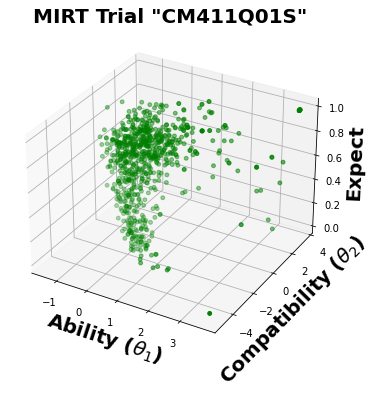

In [70]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


xs = extract_th1.copy()
ys = extract_th2.copy()
zs = rat_z.copy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ys, xs, zs, color='g', marker='o', s=15, cmap='Greens')

ax.set_title('MIRT Trial "CM411Q01S"', fontdict={'weight': 'bold', 'size': 20})
ax.set_xlabel('Ability ('r'$\theta_1$'')', fontdict={'weight': 'bold', 'size': 20})
ax.set_ylabel('Compatibility ('r'$\theta_2$'')', fontdict={'weight': 'bold', 'size': 20})
ax.set_zlabel('Expect', fontdict={'weight': 'bold', 'size': 20})

plt.show()

## To Plot in 2D

In [71]:
# Ingredient Preprocessing
seed_z = expect_model(alpha1_norm, alpha2_norm, d_norm, theta1_norm, theta2_norm)
vect_z = seed_z.copy()                     # expectation value

vect_th1 = theta1_norm[:, 0].copy()        # Ability vector
#vect_th2 = theta2_test[:, 0].copy()       # Compatibility vector

vect_real = num_df.copy()                  # real value of correct or incorrect

In [73]:
columcolum = fil4.columns
print(columcolum)
print(columcolum.shape[0])
#print(cols_list)


Index(['CM033Q01S', 'CM474Q01S', 'CM155Q01S', 'CM155Q04S', 'CM411Q01S',
       'CM411Q02S', 'CM803Q01S', 'CM442Q02S', 'CM034Q01S', 'CM305Q01S',
       'CM496Q01S', 'CM496Q02S', 'CM423Q01S', 'CM192Q01S', 'CM603Q01S',
       'CM571Q01S', 'CM564Q01S', 'CM564Q02S', 'CM447Q01S', 'CM273Q01S',
       'CM408Q01S', 'CM420Q01S', 'CM446Q01S', 'CM559Q01S', 'CM828Q03S',
       'CM464Q01S', 'CM800Q01S', 'CM982Q01S', 'CM982Q02S', 'CM982Q03S',
       'CM982Q04S', 'CM992Q01S', 'CM992Q02S', 'CM915Q01S', 'CM915Q02S',
       'CM906Q01S', 'CM909Q01S', 'CM909Q02S', 'CM909Q03S', 'CM949Q01S',
       'CM949Q02S', 'CM00GQ01S', 'CM998Q04S', 'CM905Q01S', 'CM919Q01S',
       'CM919Q02S', 'CM954Q01S', 'CM954Q04S', 'CM943Q01S', 'CM943Q02S',
       'CM953Q03S'],
      dtype='object')
51


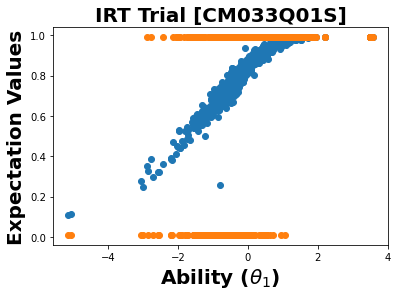

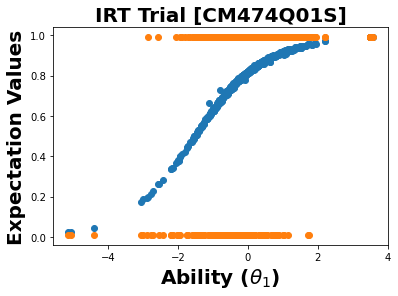

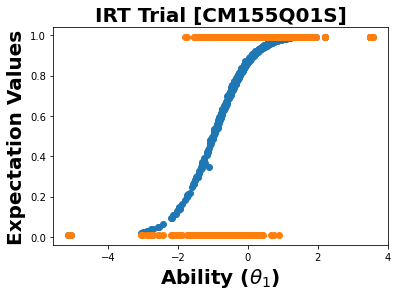

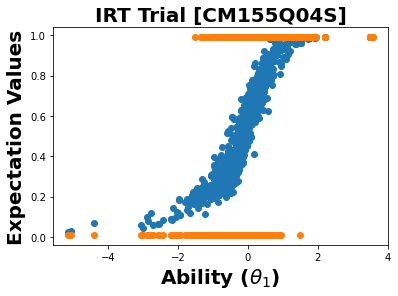

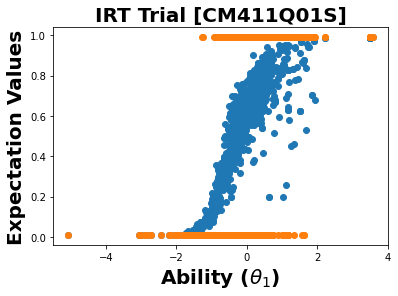

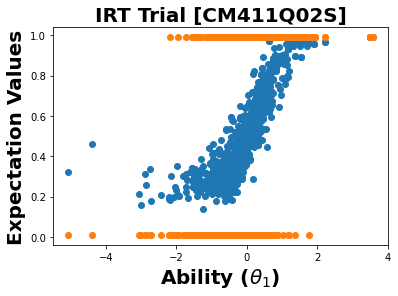

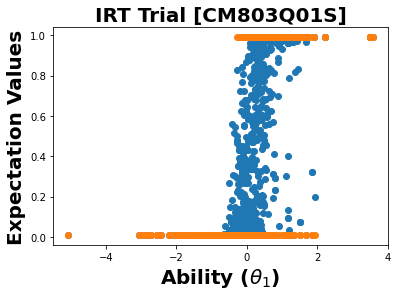

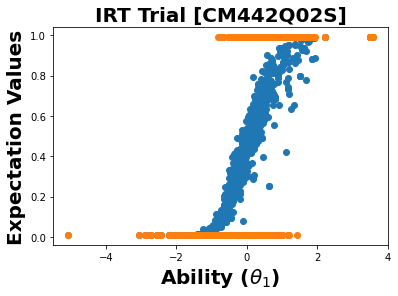

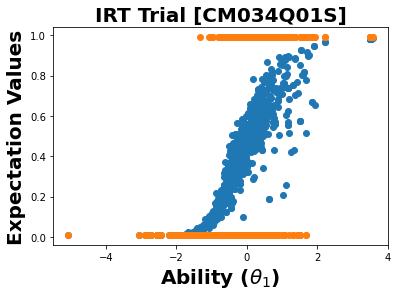

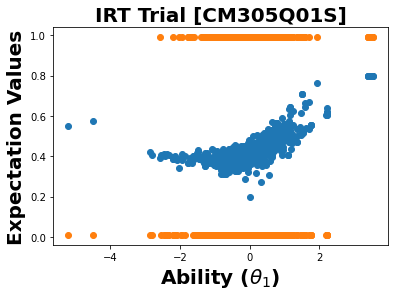

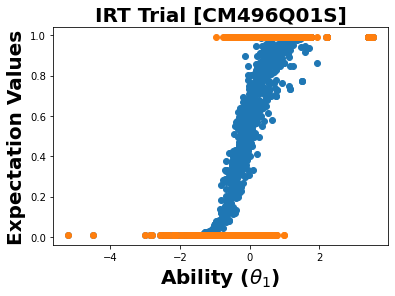

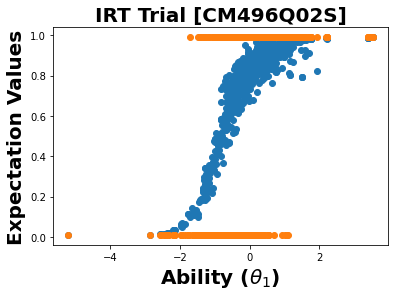

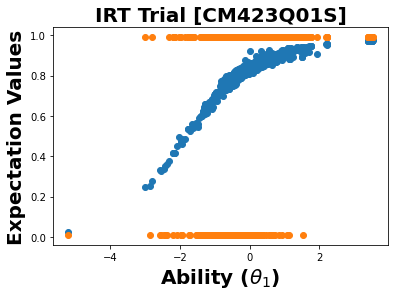

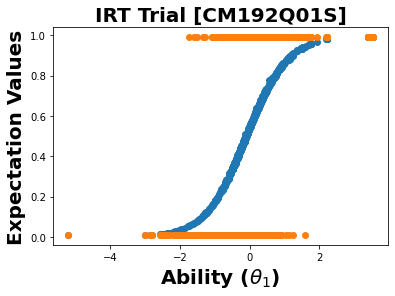

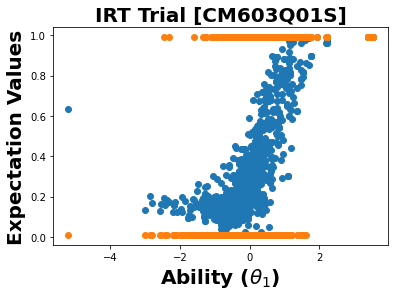

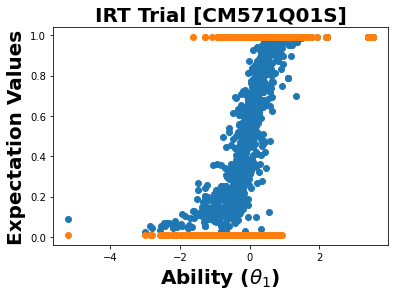

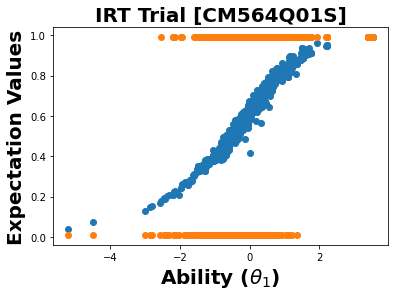

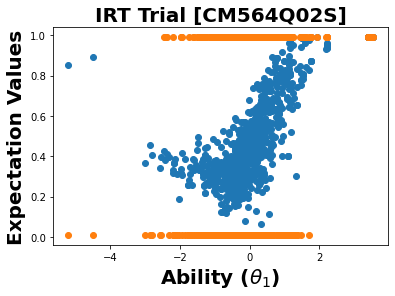

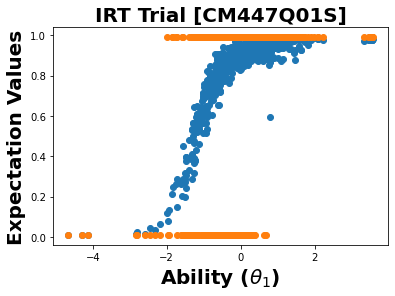

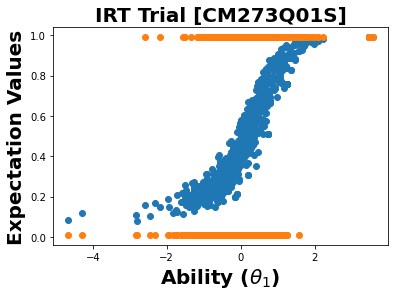

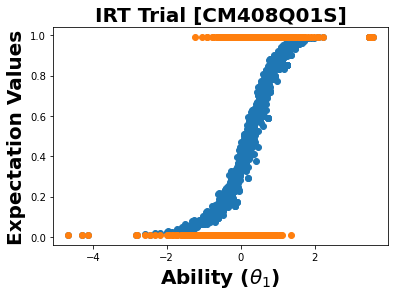

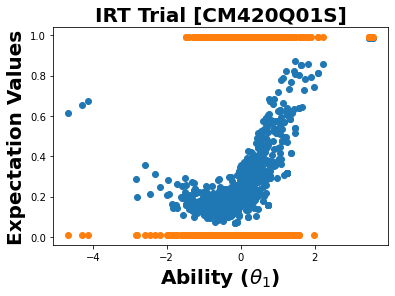

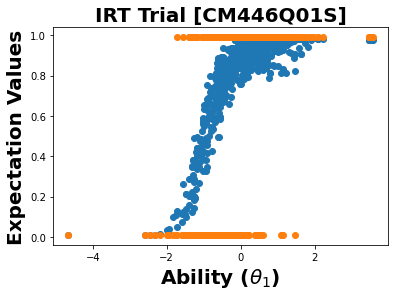

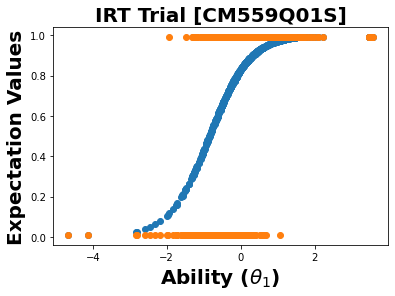

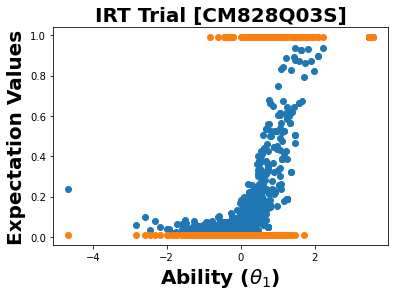

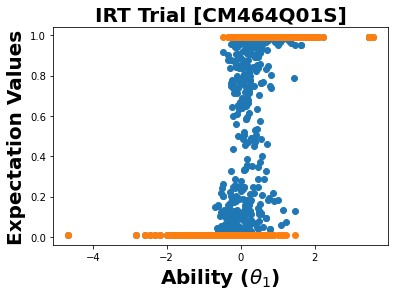

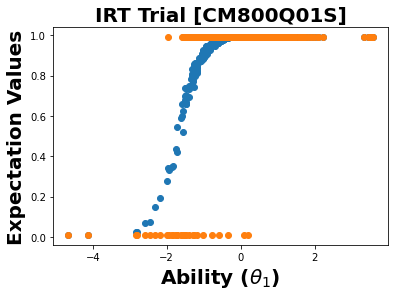

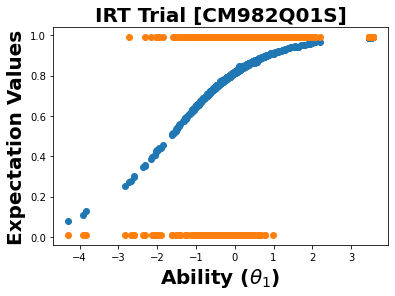

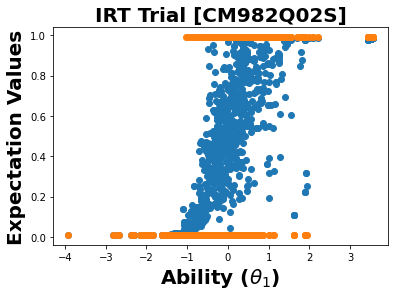

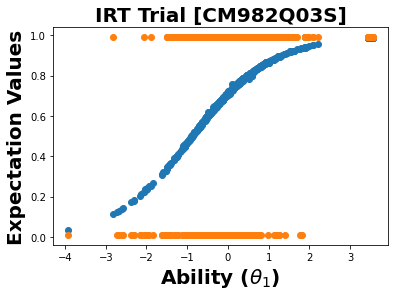

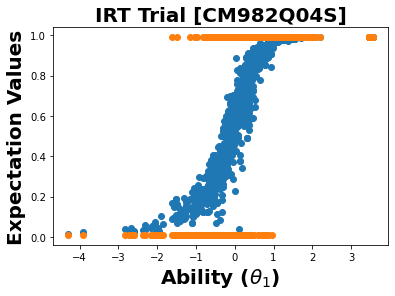

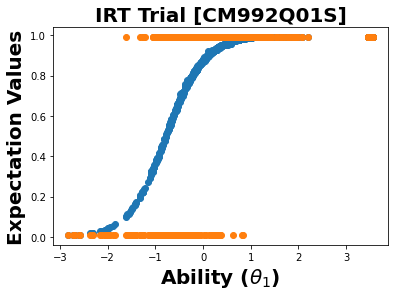

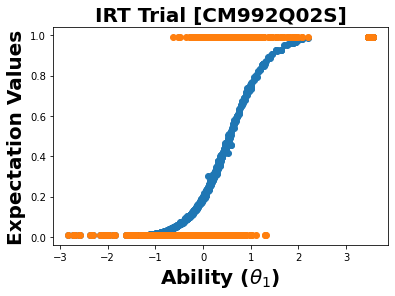

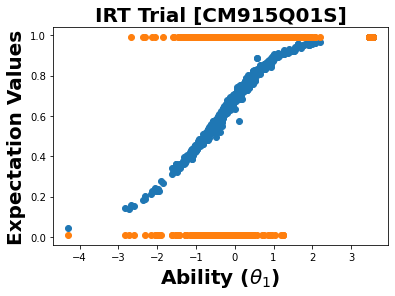

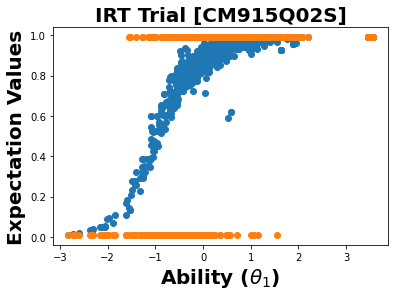

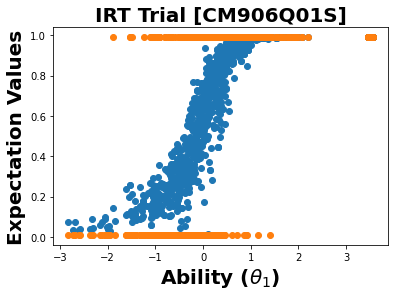

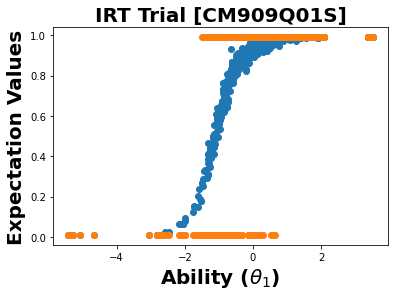

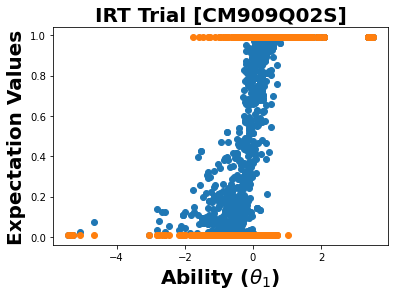

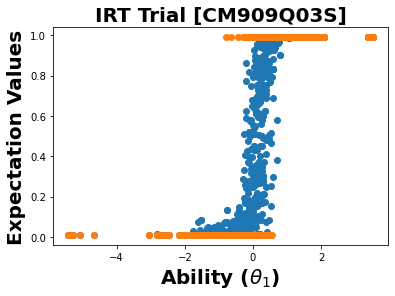

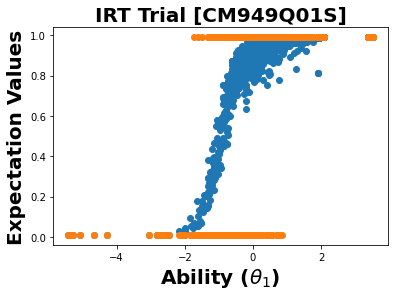

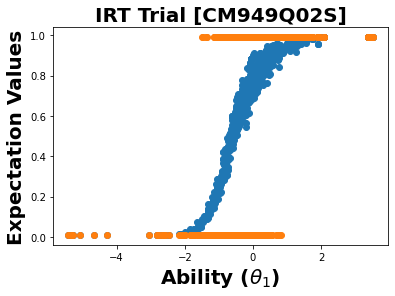

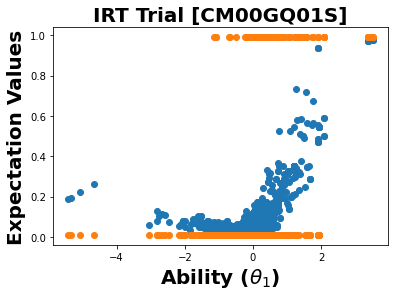

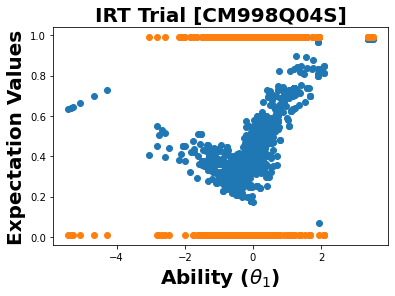

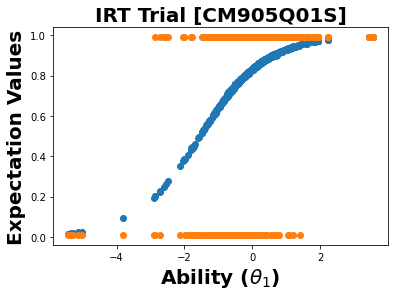

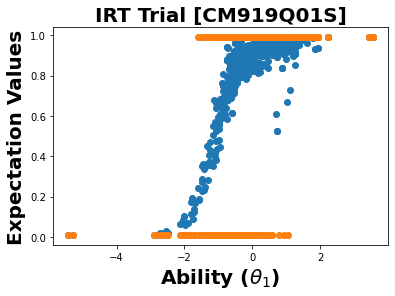

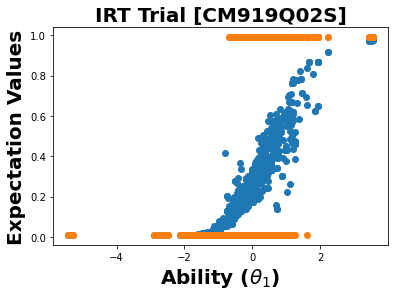

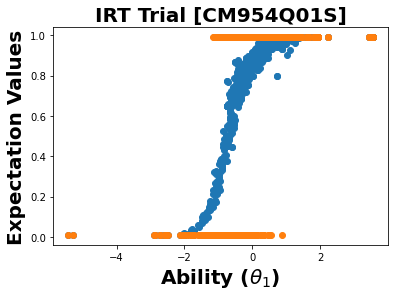

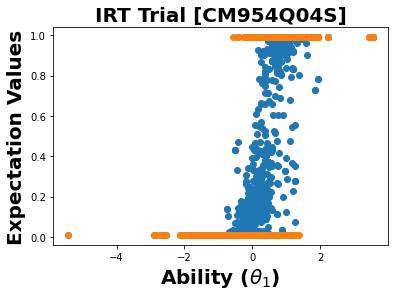

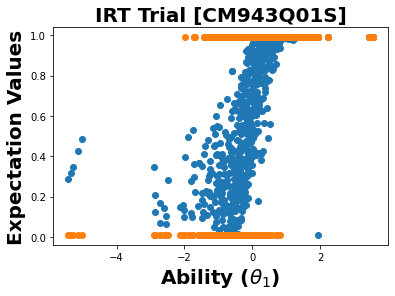

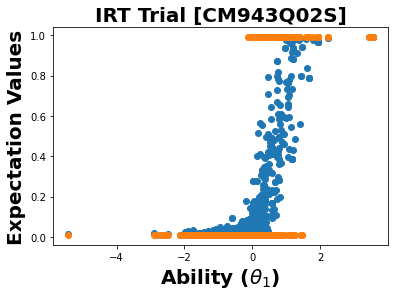

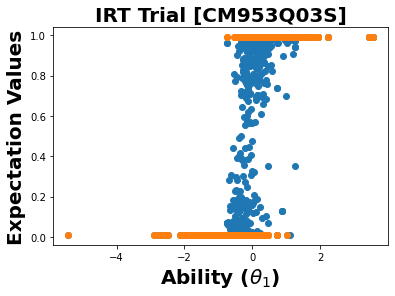

In [74]:
for i in range(seed_z.shape[1]):
    copy_th1 = vect_th1.copy()              # 다음 문제에 활용하기 위해 리셋
    copy_z = vect_z[:, i].copy()                  # 다음 문제에 활용하기 위해 리셋
    copy_real = vect_real[:, i].copy()            # 다음 문제에 활용하기 위해 리셋
    
    for j in range(seed_z[:, i].shape[0]):
        
        n = seed_z[:, i].shape[0] - (j + 1)
        
        if np.isnan(seed_z[:, i][n]):
            copy_th1 = np.delete(copy_th1, n)
            copy_z = np.delete(copy_z, n)
            copy_real = np.delete(copy_real, n)
            
    xs = copy_th1.tolist()    # Theta Column
    #print(xs)
    ys = copy_z.tolist()    # CM411Q02S Column
    #print(ys)
    zs = copy_real.tolist()   # CM411Q02S Real df Column

    plt.scatter(x=xs, y=ys)
    plt.scatter(x=xs, y=zs)

    plt.title('IRT Trial [{0}]'.format(columcolum[i]), fontdict={'weight': 'bold', 'size': 20})
    plt.xlabel('Ability ('r'$\theta_1$'')', fontdict={'weight': 'bold', 'size': 20})
    plt.ylabel('Expectation Values', fontdict={'weight': 'bold', 'size': 20})
    plt.show()
            

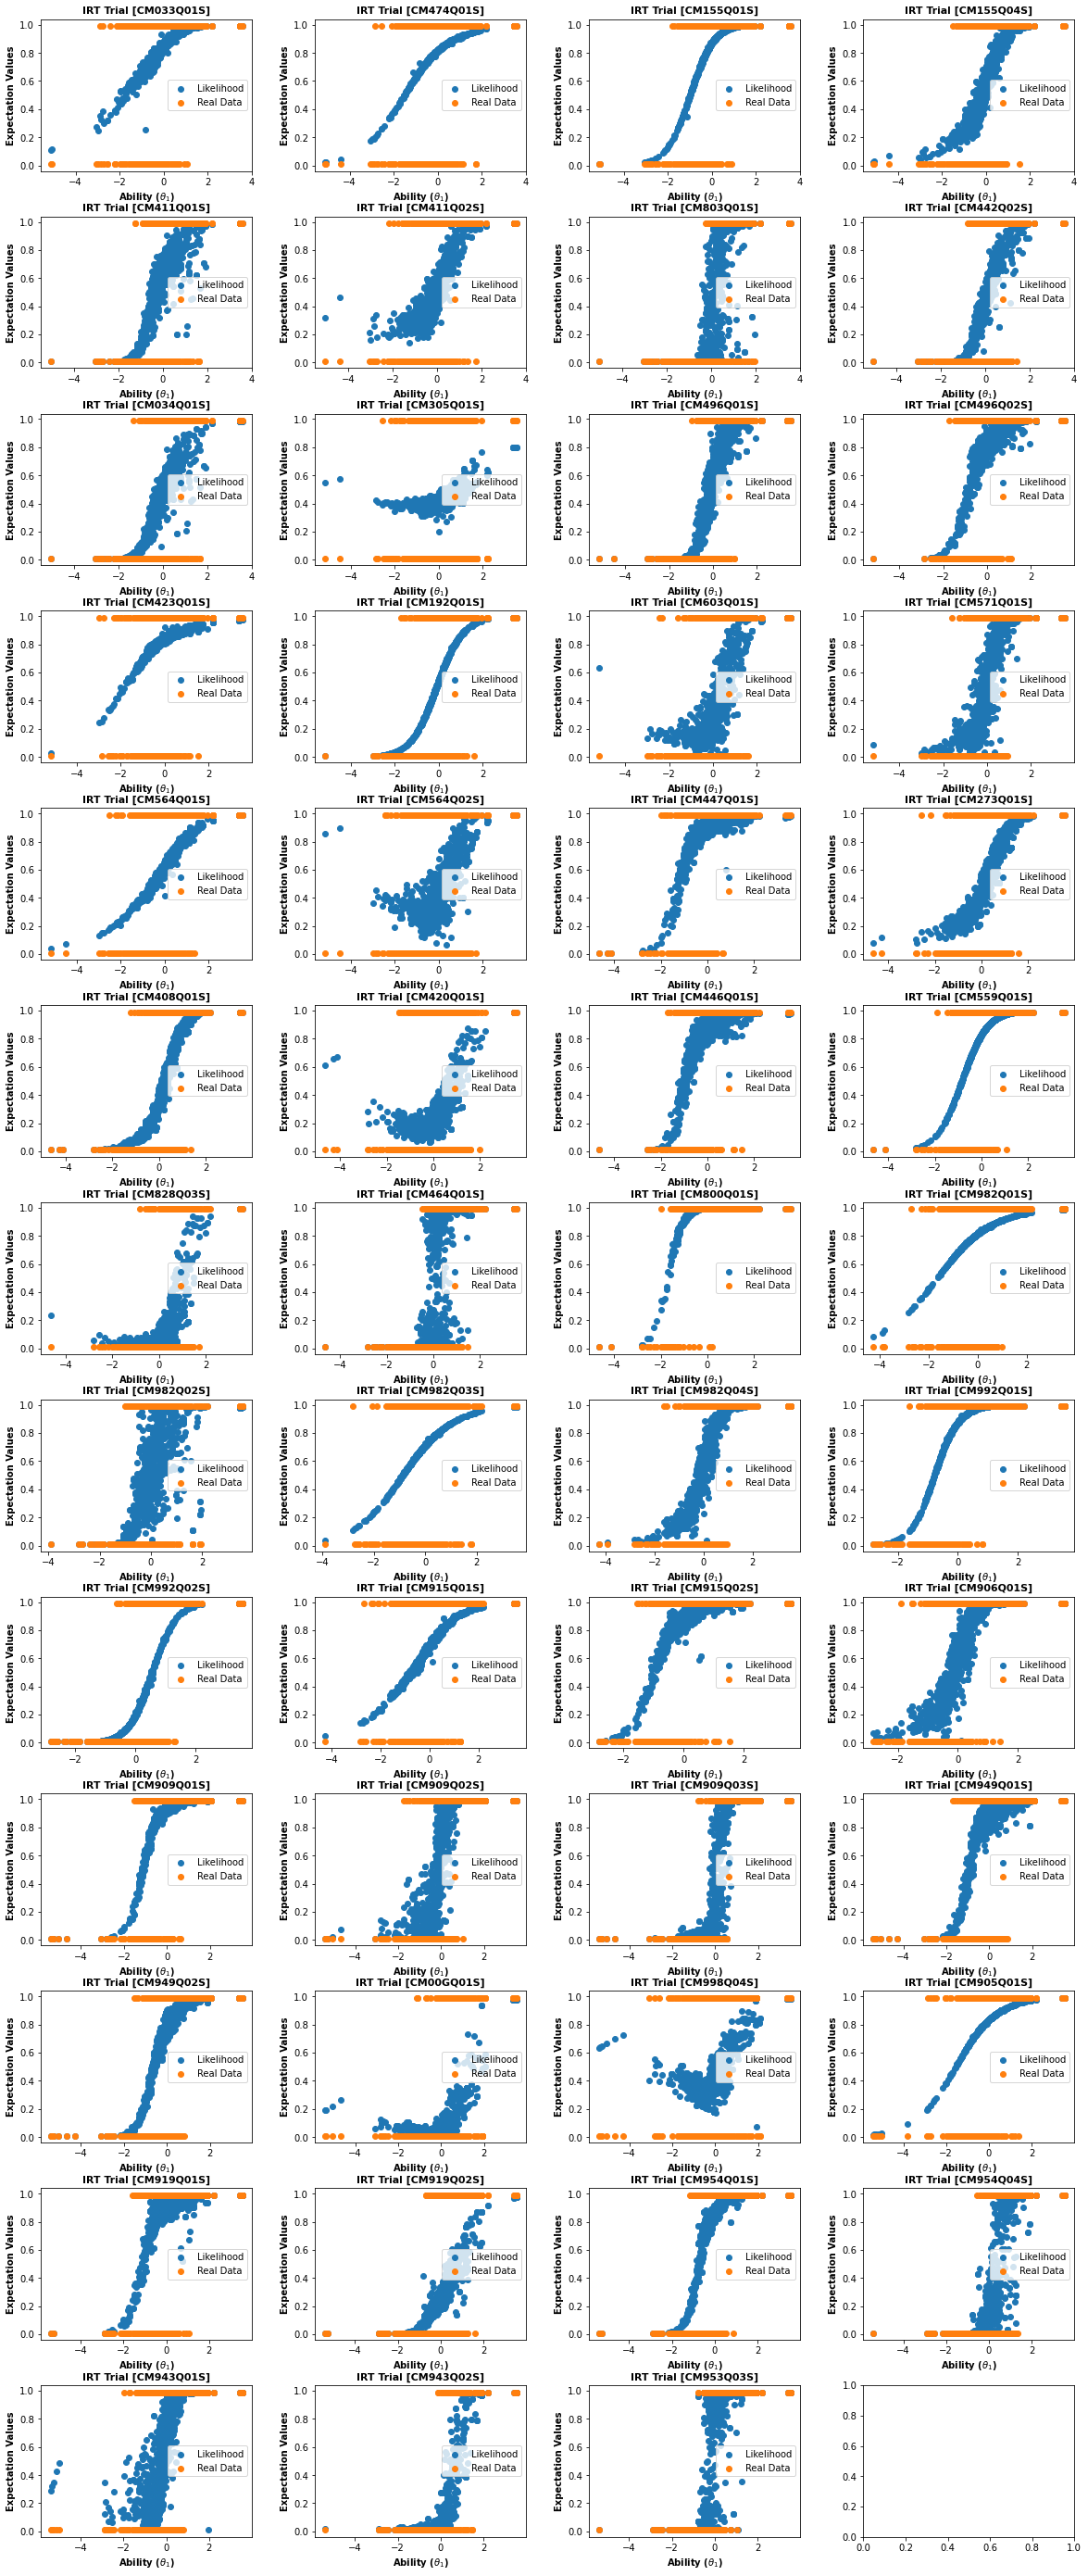

In [75]:
# 최종 plotting 결과를 격자 방식으로 나열
f, axes = plt.subplots(13, 4)
garo = 0
sero = 0

# 격자 크기 설정
f.set_size_inches((20, 50))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

# 놀고먹는 xs

# 격자 채워넣기

#start_16bit = columcolum.shape[0] // 16

#while start_16bit >= 0:
    
for i in range(seed_z.shape[1]):
    copy_th1 = vect_th1.copy()              # 다음 문제에 활용하기 위해 리셋
    copy_z = vect_z[:, i].copy()                  # 다음 문제에 활용하기 위해 리셋
    copy_real = vect_real[:, i].copy()            # 다음 문제에 활용하기 위해 리셋
    
    for j in range(seed_z[:, i].shape[0]):
        
        n = seed_z[:, i].shape[0] - (j + 1)
        
        if np.isnan(seed_z[:, i][n]):
            copy_th1 = np.delete(copy_th1, n)
            copy_z = np.delete(copy_z, n)
            copy_real = np.delete(copy_real, n)
            
    xs = copy_th1.tolist()    # Theta Column
    #print(xs)
    ys = copy_z.tolist()    # CM411Q02S Column
    #print(ys)
    zs = copy_real.tolist()   # CM411Q02S Real df Column

    axes[garo, sero].scatter(x=xs, y=ys, label='Likelihood')
    axes[garo, sero].scatter(x=xs, y=zs, label='Real Data')

    axes[garo, sero].set_title('IRT Trial [{0}]'.format(columcolum[i]), fontdict={'weight': 'bold', 'size': 11})
    axes[garo, sero].set_xlabel('Ability ('r'$\theta_1$'')', fontdict={'weight': 'bold', 'size': 10})
    axes[garo, sero].set_ylabel('Expectation Values', fontdict={'weight': 'bold', 'size': 10})
    
    axes[garo, sero].legend(loc='right')
    
    sero += 1
    garo += sero // 4
    sero = sero % 4

plt.show()

## Plot in 'Equivalent Ability'

Equilvalent Ability is introduced to confirm the tendency of changing the model by the conversion formula below.

$\theta_{eq} = \theta_1 + \frac{\alpha_2}{\alpha_1} \theta_2$ 

In this formula, the compatibility($\theta_2$) plays the role to revise the initial bias of the ability($\theta_1$).

In [76]:
print(alpha1_norm.shape)
print(theta2_norm.shape)
print(alpha1_norm[0, :])
print(alpha1_norm[0, :][50])

(1, 51)
(2727, 1)
[ 1.11699581  0.96768124  1.92871583  1.43146474  2.37047785  0.89609455
 11.95109475  2.97357802  2.17073331  0.13508005  3.41904645  1.96225813
  0.83573525  1.72216588  0.84766566  1.98881788  0.90012244  0.5200256
  1.68800752  1.14073192  1.90037408  0.47644477  2.09303861  1.87112035
  0.99624426 14.6057676   3.75882093  0.88573674  3.24214244  1.02737417
  1.95296928  2.50102828  2.62392298  1.04015996  1.98854148  2.00904469
  2.16113379  3.14917073  4.08907588  2.12616436  2.23262319  0.57213208
  0.38178367  1.02222127  2.03382132  1.96587713  2.82058121  7.36592236
  2.12222016  1.64226331 15.10159733]
15.101597332661589


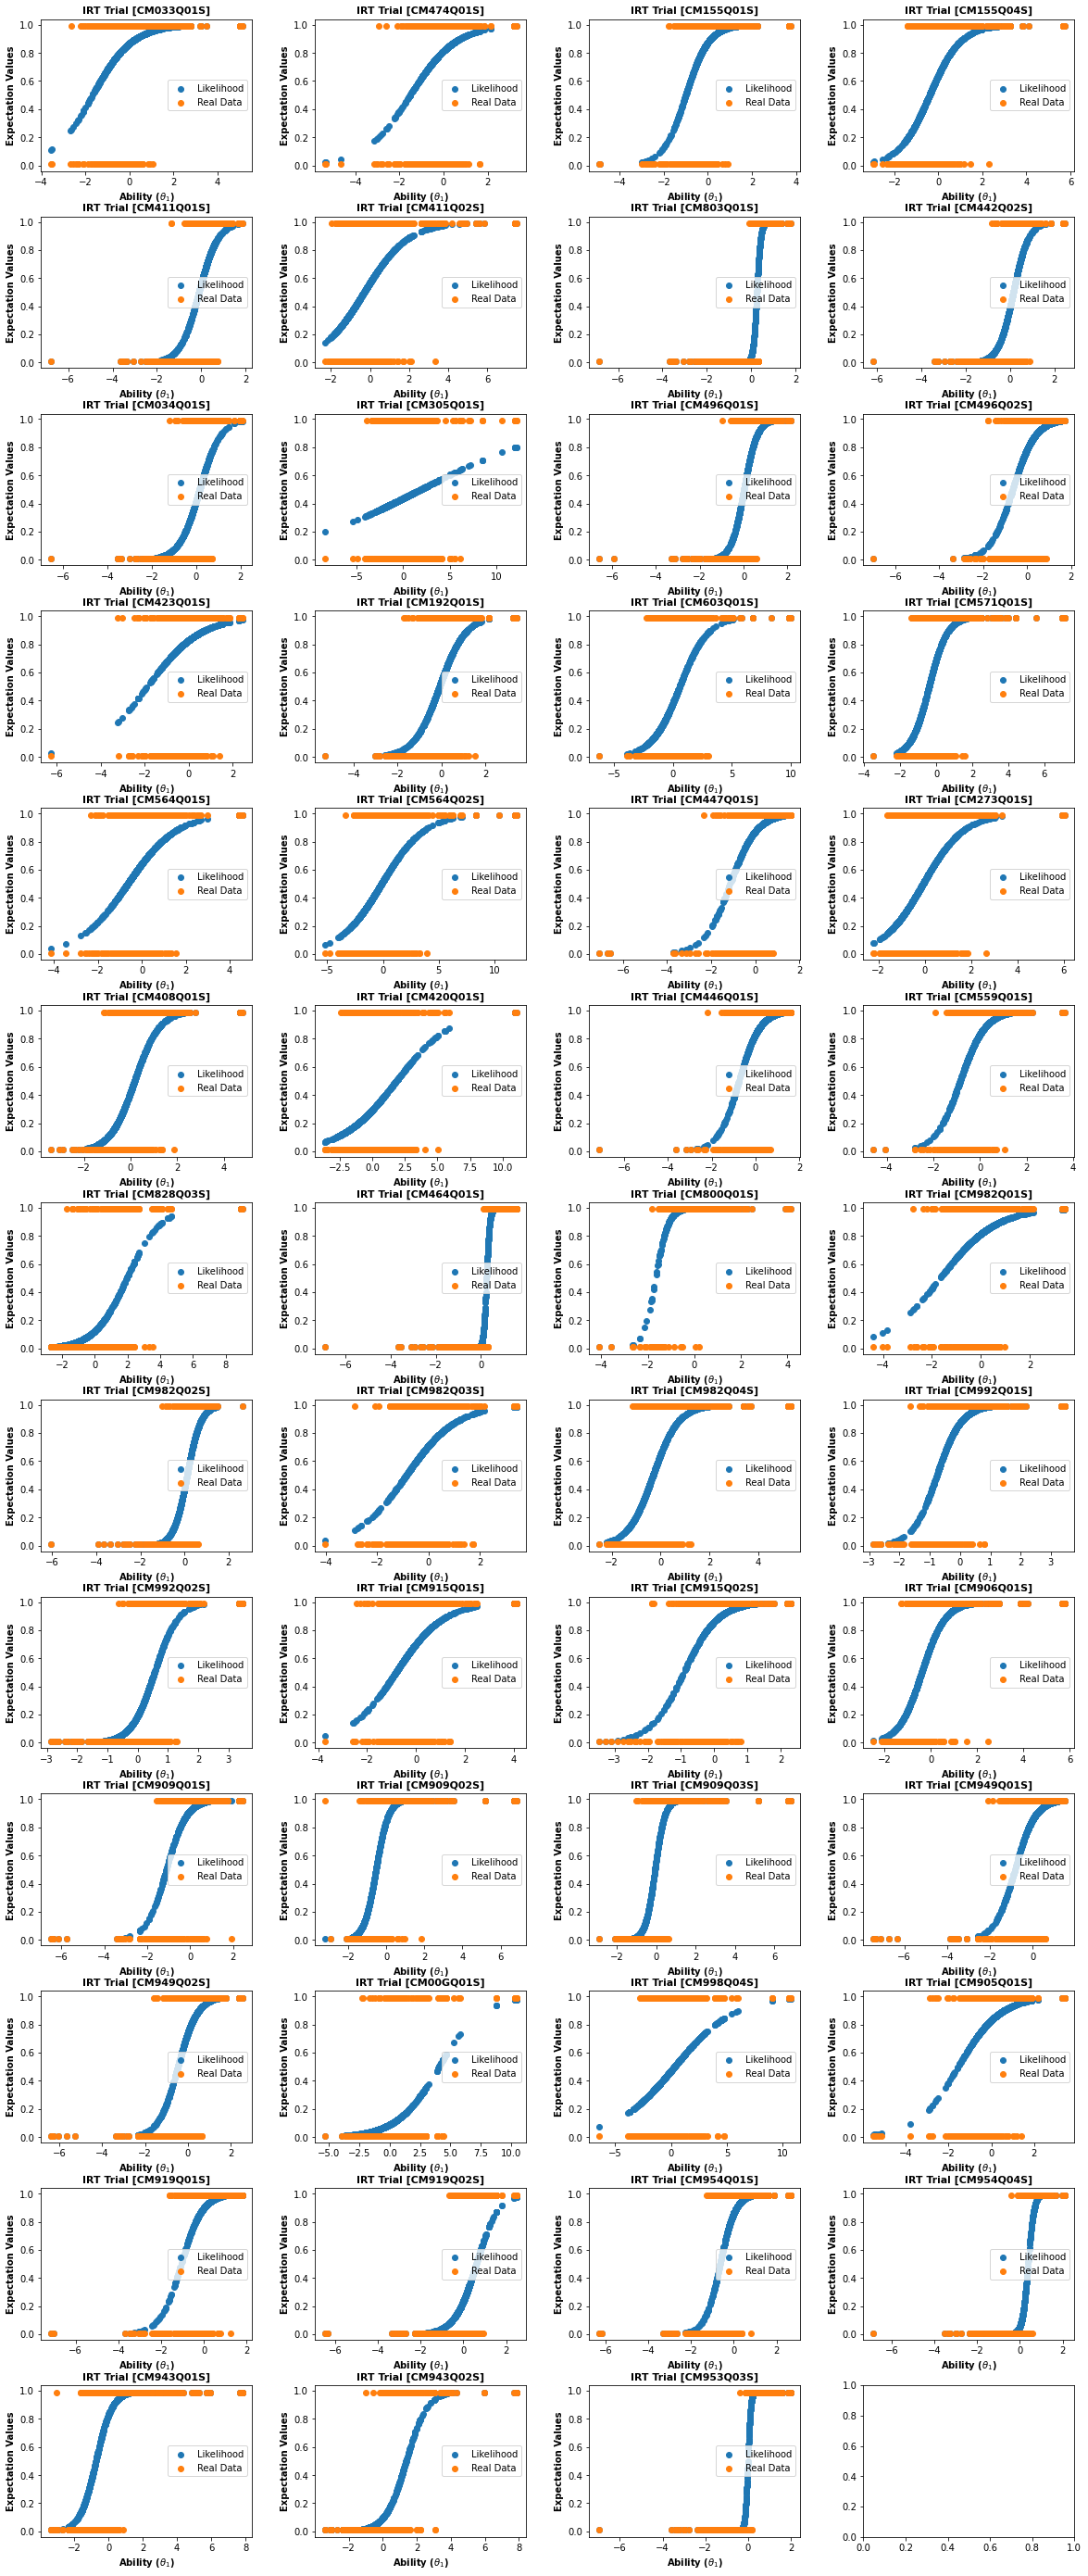

In [77]:
# 최종 plotting 결과를 격자 방식으로 나열
f, axes = plt.subplots(13, 4)
garo = 0
sero = 0

copy_th1 = vect_th1.copy()
copy_th2 = theta2_norm[:, 0].copy()
copy_al1 = alpha1_norm[0, :].copy()
copy_al2 = alpha2_norm[0, :].copy()

# 격자 크기 설정
f.set_size_inches((20, 50))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

# 놀고먹는 xs

# 격자 채워넣기

#start_16bit = columcolum.shape[0] // 16

#while start_16bit >= 0:
    
for i in range(seed_z.shape[1]):
    th_eq = copy_th1 + ((copy_al2[i]) / (copy_al1[i])) * copy_th2
    copy_z = vect_z[:, i].copy()                  # 다음 문제에 활용하기 위해 리셋
    copy_real = vect_real[:, i].copy()            # 다음 문제에 활용하기 위해 리셋
    
    for j in range(seed_z[:, i].shape[0]):
        
        n = seed_z[:, i].shape[0] - (j + 1)
        
        if np.isnan(seed_z[:, i][n]):
            th_eq = np.delete(th_eq, n)
            copy_z = np.delete(copy_z, n)
            copy_real = np.delete(copy_real, n)
            
    xs = th_eq.tolist()    # Theta Column
    #print(xs)
    ys = copy_z.tolist()    # CM411Q02S Column
    #print(ys)
    zs = copy_real.tolist()   # CM411Q02S Real df Column

    axes[garo, sero].scatter(x=xs, y=ys, label='Likelihood')
    axes[garo, sero].scatter(x=xs, y=zs, label='Real Data')

    axes[garo, sero].set_title('IRT Trial [{0}]'.format(columcolum[i]), fontdict={'weight': 'bold', 'size': 11})
    axes[garo, sero].set_xlabel('Ability ('r'$\theta_1$'')', fontdict={'weight': 'bold', 'size': 10})
    axes[garo, sero].set_ylabel('Expectation Values', fontdict={'weight': 'bold', 'size': 10})
    
    axes[garo, sero].legend(loc='right')
    
    sero += 1
    garo += sero // 4
    sero = sero % 4

plt.show()

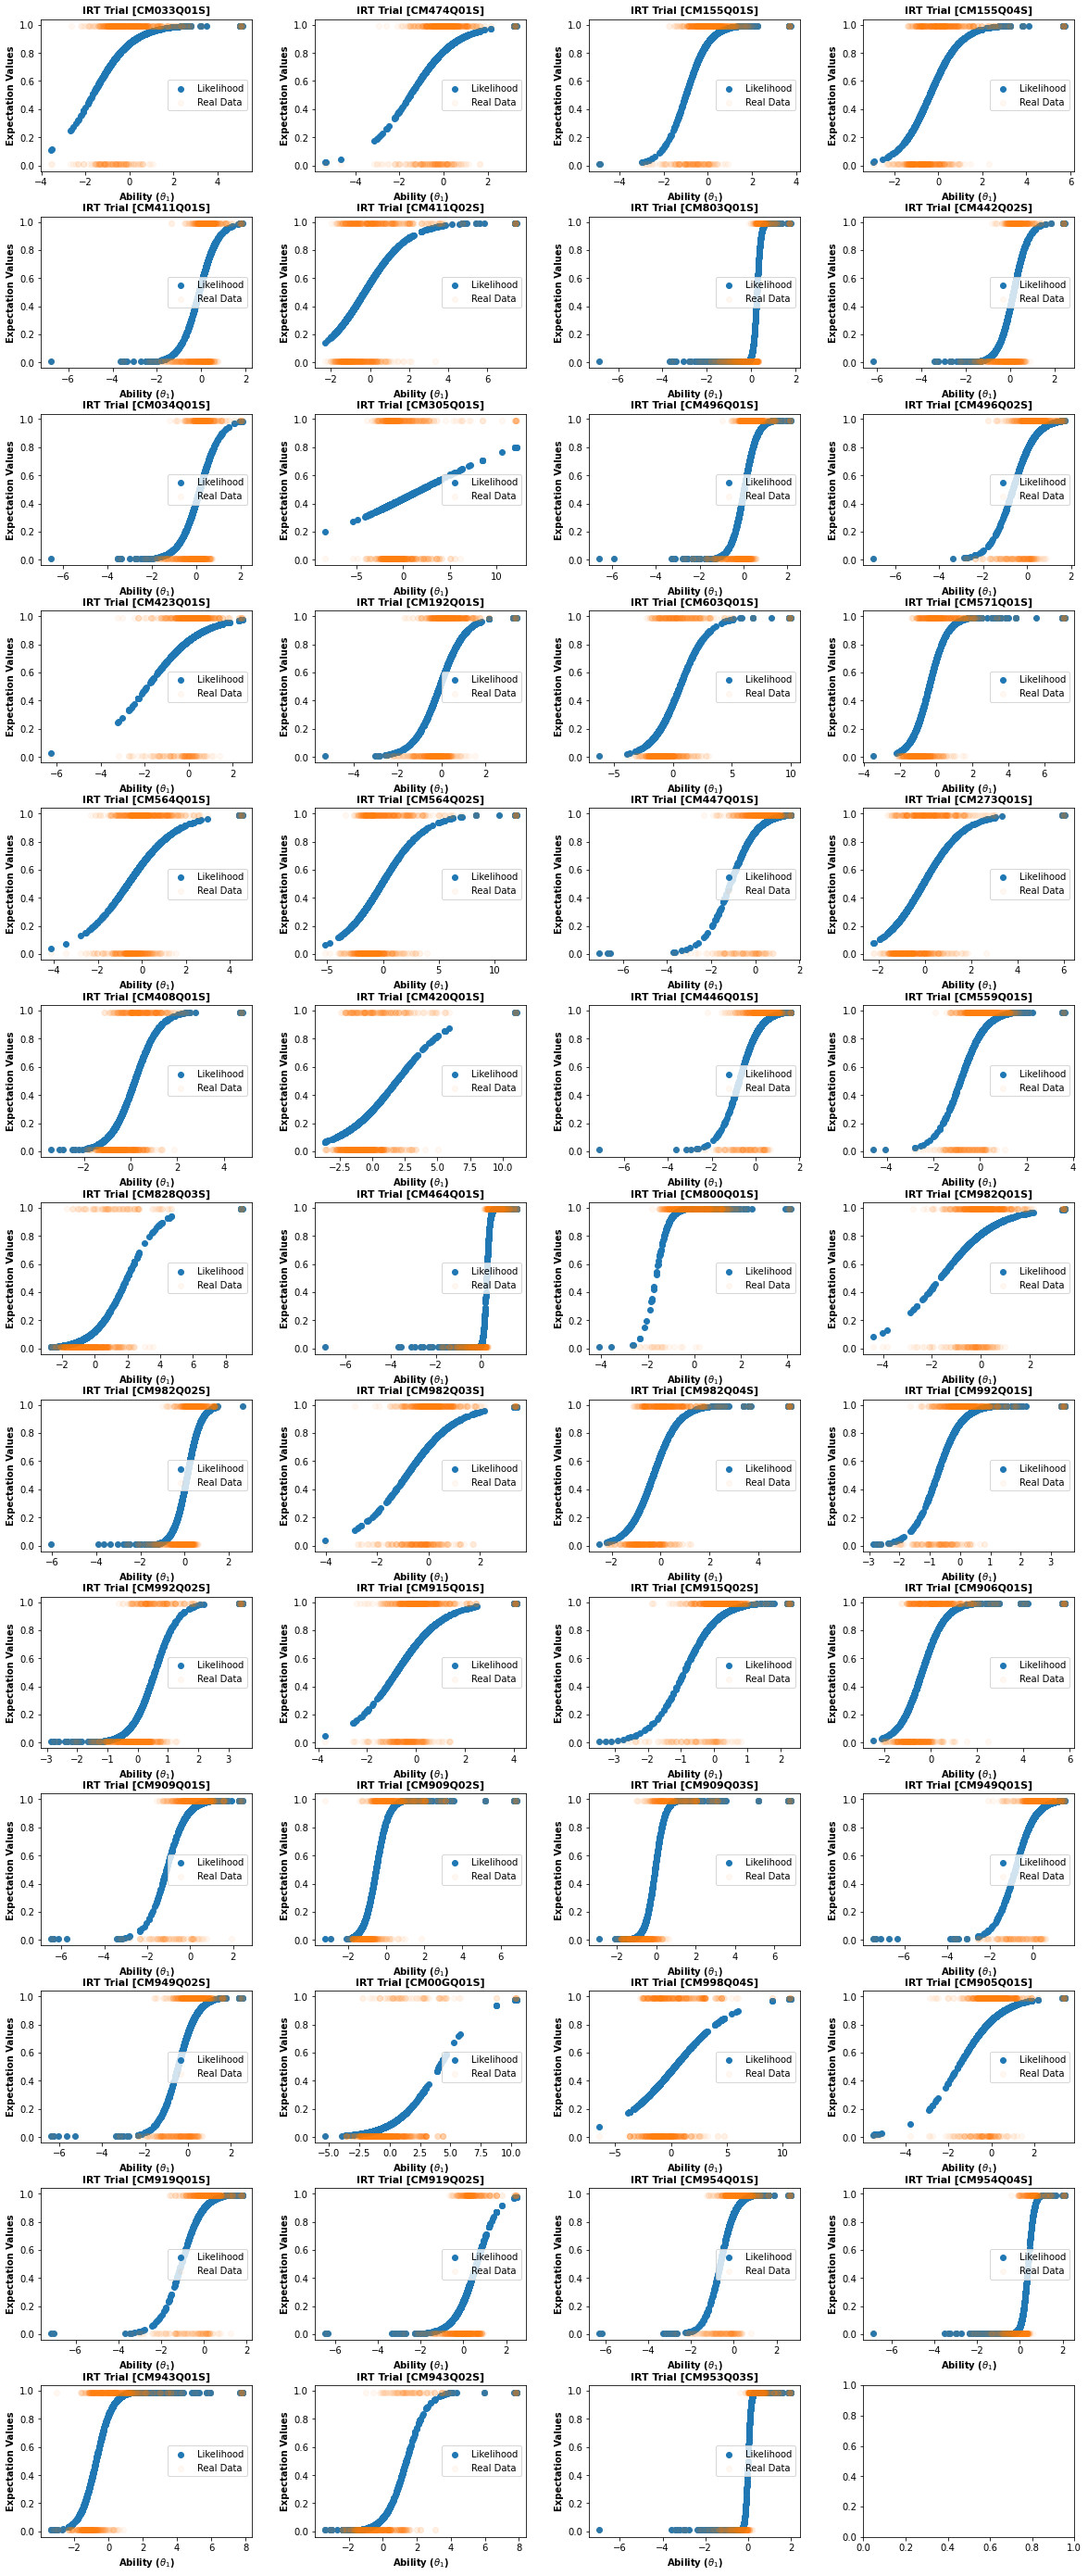

In [78]:
# 최종 plotting 결과를 격자 방식으로 나열
f, axes = plt.subplots(13, 4)
garo = 0
sero = 0

copy_th1 = vect_th1.copy()
copy_th2 = theta2_norm[:, 0].copy()
copy_al1 = alpha1_norm[0, :].copy()
copy_al2 = alpha2_norm[0, :].copy()

# 격자 크기 설정
f.set_size_inches((20, 50))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

# 놀고먹는 xs

# 격자 채워넣기

#start_16bit = columcolum.shape[0] // 16

#while start_16bit >= 0:
    
for i in range(seed_z.shape[1]):
    th_eq = copy_th1 + ((copy_al2[i]) / (copy_al1[i])) * copy_th2
    copy_z = vect_z[:, i].copy()                  # 다음 문제에 활용하기 위해 리셋
    copy_real = vect_real[:, i].copy()            # 다음 문제에 활용하기 위해 리셋
    
    for j in range(seed_z[:, i].shape[0]):
        
        n = seed_z[:, i].shape[0] - (j + 1)
        
        if np.isnan(seed_z[:, i][n]):
            th_eq = np.delete(th_eq, n)
            copy_z = np.delete(copy_z, n)
            copy_real = np.delete(copy_real, n)
            
    xs = th_eq.tolist()    # Theta Column
    #print(xs)
    ys = copy_z.tolist()    # CM411Q02S Column
    #print(ys)
    zs = copy_real.tolist()   # CM411Q02S Real df Column

    axes[garo, sero].scatter(x=xs, y=ys, label='Likelihood')
    axes[garo, sero].scatter(x=xs, y=zs, label='Real Data', alpha=0.05)

    axes[garo, sero].set_title('IRT Trial [{0}]'.format(columcolum[i]), fontdict={'weight': 'bold', 'size': 11})
    axes[garo, sero].set_xlabel('Ability ('r'$\theta_1$'')', fontdict={'weight': 'bold', 'size': 10})
    axes[garo, sero].set_ylabel('Expectation Values', fontdict={'weight': 'bold', 'size': 10})
    
    axes[garo, sero].legend(loc='right')
    
    sero += 1
    garo += sero // 4
    sero = sero % 4

plt.show()

## The Plot in 3D Again

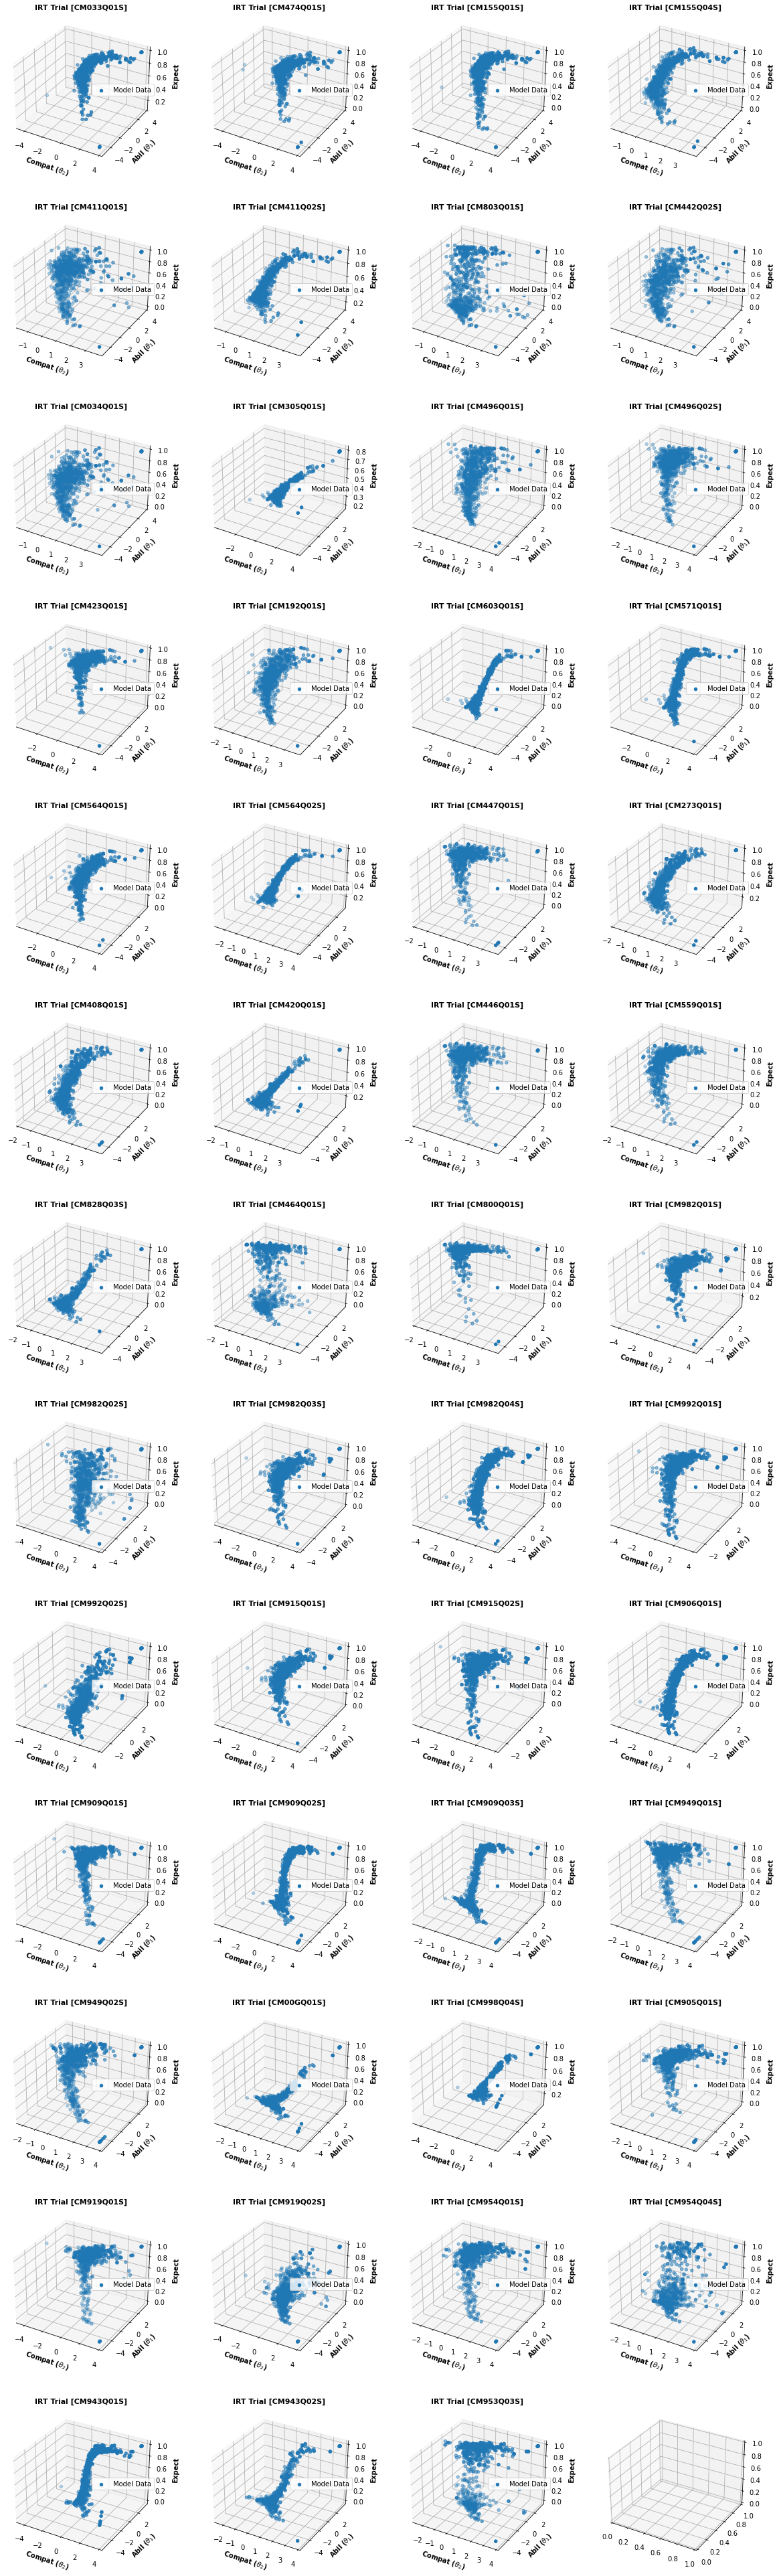

In [79]:
# 최종 plotting 결과를 격자 방식으로 나열
fig, axs = plt.subplots(nrows=13, ncols=4, figsize=(20, 70), 
                        subplot_kw={"projection":"3d"})

garo = 0
sero = 0

copy_th1 = vect_th1.copy()                       # Ability theta 복사
copy_th2 = theta2_norm[:, 0].copy()              # Compatibility theta 복사

# 격자 크기 설정
f.set_size_inches((20, 50))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)


# 격자 채워넣기

for i in range(seed_z.shape[1]):
    cat_th1 = copy_th1.copy()                     # 다음 문제에 활용하기 위해 리셋
    cat_th2 = copy_th2.copy()                     # 다음 문제에 활용하기 위해 리셋
    copy_z = vect_z[:, i].copy()                  # 다음 문제에 활용하기 위해 리셋
    copy_real = vect_real[:, i].copy()            # 다음 문제에 활용하기 위해 리셋
    
    for j in range(seed_z[:, i].shape[0]):
        
        n = seed_z[:, i].shape[0] - (j + 1)       # 뒷쪽 리스트 성분부터 삭제 (index number 꼬이는거 방지)
        
        if np.isnan(seed_z[:, i][n]):             # seez_z에서 NaN 발견되는 순간, 여기에 해당하는 모든 theta 동시 삭제
            cat_th1 = np.delete(cat_th1, n)
            cat_th2 = np.delete(cat_th2, n)
            copy_z = np.delete(copy_z, n)
            copy_real = np.delete(copy_real, n)
            
    xs = cat_th1.tolist()    # Ability theta가 x축
    ys = cat_th2.tolist()    # Compatibility theta가 y축
    z1 = copy_z.tolist()     # Model로 계산한 값
    z2 = copy_real.tolist()   # 정오표에 기록된 실제 데이터

    axs[garo, sero].scatter(xs=ys, ys=xs, zs=z1, marker='o', cmap='inferno', label='Model Data')
    #axs[garo, sero].scatter(xs=xs, ys=ys, zs=z2, marker='X', cmap='Greens', label='Real Data')

    axs[garo, sero].set_title('IRT Trial [{0}]'.format(columcolum[i]), fontdict={'weight': 'bold', 'size': 11})
    axs[garo, sero].set_ylabel('Abil ('r'$\theta_1$'')', fontdict={'weight': 'bold', 'size': 10})
    axs[garo, sero].set_xlabel('Compat ('r'$\theta_2$'')', fontdict={'weight': 'bold', 'size': 10})
    axs[garo, sero].set_zlabel('Expect', fontdict={'weight': 'bold', 'size': 10})
    
    axs[garo, sero].legend(loc='right')
    
    sero += 1
    garo += sero // 4    # 오른쪽으로 한 칸씩 전진, 한 줄에 4개 모두 다 차면 줄 바꾸기 (숫자 범위: 0~3)
    sero = sero % 4      # 가로 4줄 모두 다 차면 Plot할 줄 바꾸기 (index 나누기 4의 몫에 해당)
    
plt.show()

## Comparison with existing theta

In [80]:
theta_ex = pd.read_csv("theta_norm_T.csv")
print(theta_ex)

      Unnamed: 0         0
0              0  0.729779
1              1  0.295815
2              2  0.191161
3              3 -0.171805
4              4  0.557345
...          ...       ...
2722        2722  0.203124
2723        2723 -1.034252
2724        2724  0.674030
2725        2725 -1.247872
2726        2726 -0.183229

[2727 rows x 2 columns]


In [81]:
theta_pr2 = theta_ex.iloc[:, 1].to_numpy()
print(theta_pr2)
print(theta_pr2.shape)

[ 0.72977913  0.29581539  0.19116132 ...  0.67402977 -1.24787226
 -0.18322867]
(2727,)


In [13]:
# Now, it is time to compare two thetas in the end!!

import matplotlib.pylab as pylab
from sklearn.metrics import r2_score

In [83]:
theta_now = theta1_norm.copy()
theta_nowT = np.transpose(theta_now)
theta_now_fin = theta_nowT[0, :]
print(theta_now_fin)
print(theta_now_fin.shape)

[ 0.69173029  0.32543069  0.10560578 ...  0.66671391 -0.98106242
 -0.04615287]
(2727,)


In [84]:
x = theta_pr2
y = theta_now_fin
R2 = r2_score(x, y)
print(R2)

0.9566042373315251


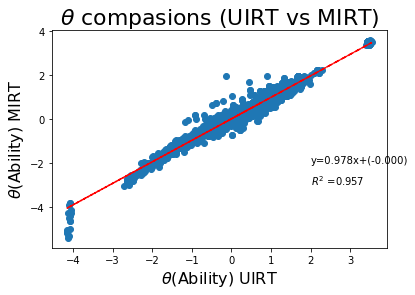

In [85]:
z = np.polyfit(x, y, 1) # (X,Y,차원) 정의
p = np.poly1d(z) # 1차원 다항식에 대한 연산을 캡슐화

pylab.plot(x, y,'o')
pylab.plot(x,p(x),"r--")
pylab.xlabel(r'$\theta$' "(Ability) UIRT", fontdict={'size': 16})
pylab.ylabel(r'$\theta$' "(Ability) MIRT", fontdict={'size': 16})
pylab.title(r'$\theta$' " compasions (UIRT vs MIRT)", fontdict={'size': 22})
pylab.text(2,-2, "y=%.3fx+(%.3f)"%(z[0],z[1]), fontdict={'size': 10})
pylab.text(2,-3, r'$R^2$'" =%.3f"% R2, fontdict={'size': 10})
pylab.show()

## Comparison with two initial thetas (Ability vs Compatibility)

In [8]:
theta_1_mean = np.mean(theta_1)
theta_1_std = np.std(theta_1)
theta_2_mean = np.mean(theta_2)
theta_2_std = np.std(theta_2)

theta_1_norm = (theta_1 - theta_1_mean) / theta_1_std
theta_2_norm = (theta_2 - theta_2_mean) / theta_2_std

alpha_1_norm = theta_1_std * alpha
alpha_2_norm = theta_2_std * alpha

d_norm = d - theta_1_mean * alpha - theta_2_mean * alpha

In [11]:
theta_now20 = theta_1_norm.copy()
theta_nowT20 = np.transpose(theta_now20)
theta_now_fin20 = theta_nowT20[0, :]
print(theta_now_fin20)
print(theta_now_fin20.shape)

[ 0.84332058  0.30303266  0.15633691 ...  0.90167705 -1.12374637
 -0.42845808]
(2727,)


In [9]:
theta_comp20 = theta_2_norm.copy()
theta_compT20 = np.transpose(theta_comp20)
theta_comp_fin20 = theta_compT20[0, :]
print(theta_comp_fin20)
print(theta_comp_fin20.shape)

[ 0.37863404 -0.26210296 -0.38534443 ...  0.46324261 -0.16091266
 -0.58651659]
(2727,)


In [14]:
x_20 = theta_now_fin20               # Ability
y_20 = theta_comp_fin20              # Compatibility
R20 = r2_score(x_20, y_20)
print(R20)

z_20 = np.polyfit(x_20, y_20, 1) # (X,Y,차원) 정의
p_20 = np.poly1d(z_20) # 1차원 다항식에 대한 연산을 캡슐화

-0.14727757456757606


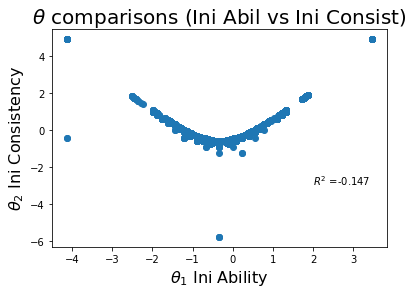

In [15]:
pylab.plot(x_20, y_20,'o')
pylab.xlabel(r'$\theta_1$' " Ini Ability", fontdict={'size': 16})
pylab.ylabel(r'$\theta_2$' " Ini Consistency", fontdict={'size': 16})
pylab.title(r'$\theta$' " comparisons (Ini Abil vs Ini Consist)", fontdict={'size': 20})
pylab.text(2,-3, r'$R^2$'" =%.3f"% R20, fontdict={'size': 10})
pylab.show()

## Comparison with two thetas (Ability vs Compatibility)

In [86]:
theta_comp = theta2_norm.copy()
theta_compT = np.transpose(theta_comp)
theta_comp_fin = theta_compT[0, :]
print(theta_comp_fin)
print(theta_comp_fin.shape)

[ 0.10197371  0.50600538 -0.64230496 ...  0.43808669 -0.55129508
 -0.75194978]
(2727,)


In [87]:
x_2 = theta_now_fin               # Ability
y_2 = theta_comp_fin              # Compatibility
R2 = r2_score(x_2, y_2)
print(R2)

z_2 = np.polyfit(x_2, y_2, 1) # (X,Y,차원) 정의
p_2 = np.poly1d(z_2) # 1차원 다항식에 대한 연산을 캡슐화

-0.20577494824104714


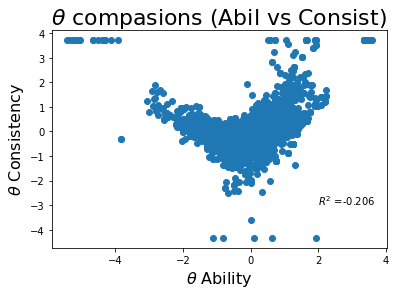

In [88]:
pylab.plot(x_2, y_2,'o')
pylab.xlabel(r'$\theta$' " Ability", fontdict={'size': 16})
pylab.ylabel(r'$\theta$' " Consistency", fontdict={'size': 16})
pylab.title(r'$\theta$' " compasions (Abil vs Consist)", fontdict={'size': 22})
pylab.text(2,-3, r'$R^2$'" =%.3f"% R2, fontdict={'size': 10})
pylab.show()

## Comparison between $\beta$ of UIRT and d of MIRT

In [89]:
beta_U = pd.read_csv("beta_norm.csv")
d_M = d_test[0, :]

In [90]:
beta_U_bf = beta_U.to_numpy()
beta_U_np = beta_U_bf[0, 1:]

In [91]:
x3 = beta_U_np.copy()
y4 = d_M.copy()
#R2_5 = r2_score(y4, x3)

z4 = np.polyfit(x3, y4, 1) # (X,Y,차원) 정의
p4 = np.poly1d(z4) # 1차원 다항식에 대한 연산을 캡슐화


In [92]:
print(z4[0])
y_pred = z4[0] * x3
print(y_pred)

1.7020510064632215
[-2.80846337 -2.67744817 -1.80386133 -0.45243107 -0.40424548 -0.23680652
  0.68774143  0.27836632  0.29562732  1.63036409 -0.17202824 -1.55814522
 -3.1944214  -0.14669208  0.93606578 -0.1371919  -0.92836277  0.32731068
 -2.35446195  0.1677334   0.44968096  2.26161252 -1.83307121 -1.44387567
  1.84293475  0.26800727 -3.13145903 -2.90984151  0.13682622 -1.47604667
 -0.27842188 -1.41635228  1.03996089 -1.32715308 -1.85655413 -0.34852082
 -1.91414788 -0.27082173  0.31252034 -1.89944705 -1.05198705  2.70230303
  0.61629094 -2.79538312 -2.22275306  1.33513644 -1.39127012  1.06670494
 -0.86594326  1.35748064 -0.32727209]


In [93]:

R2_6 = r2_score(y4, y_pred)
print("The R^2 score between 'beta of UIRT' and 'd of MIRT' : ")
print(R2_6)
print(" ")


The R^2 score between 'beta of UIRT' and 'd of MIRT' : 
0.6084040672195479
 


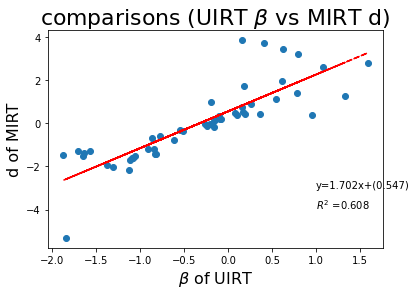

In [94]:
pylab.plot(x3, y4,'o')
pylab.plot(x3,p4(x3),"r--")

pylab.xlabel(r'$\beta$' " of UIRT", fontdict={'size': 16})
pylab.ylabel("d of MIRT", fontdict={'size': 16})
pylab.title("comparisons (UIRT " r'$\beta$' " vs MIRT d)", fontdict={'size': 22})
pylab.text(1,-3, "y=%.3fx+(%.3f)"%(z4[0],z4[1]), fontdict={'size': 10})
pylab.text(1,-4, r'$R^2$'" =%.3f"% R2_6, fontdict={'size': 10})
pylab.show()